# Deep Learning Project

## Initial Setup

In [1]:
from torchvision.datasets import CIFAR10
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
from timeit import default_timer as timer
from dataset import CIFAR10Dataset
from utils import *
from networks import *
import random
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import itertools

random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

EPOCHS = 100
TRAIN = False
TEST_BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MEAN = torch.tensor([0.4914, 0.4822, 0.4465])
STD = torch.tensor([0.2023, 0.1994, 0.2010])
TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

CLASSES = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

train_dataset_norm = CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=TRANSFORM
)
test_dataset_norm = CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=TRANSFORM
)

Best models parameters

In [2]:
TINY_VGG_BEST_PARAMS = {
    'hidden_units': 128,
    'batch_size': 128
}

RESNET_BEST_PARAMS = {
    'hidden_units': 128,
    'batch_size': 64
}

GRU_BEST_PARAMS = {
    'hidden_units': 128,
    'num_layers': 4,
    'batch_size': 64
}

VIT_BEST_PARAMS = {
    'embed_dim': 64,
    'depth': 8,
    'mlp_dim': 512,
    'batch_size': 32
}

MLP_MIXER_BEST_PARAMS = {
    'embed_dim': 64,
    'depth': 6,
    'token_intermediate_dim': 64,
    'channel_intermediate_dim': 128,
    'batch_size': 32
}

Calculation of the normalization parameters

In [3]:
train_dataset = CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

mean, std = get_mean_std(train_dataset)
print(f"Mean: {mean}, Std: {std}")

Mean: tensor([0.4914, 0.4822, 0.4465]), Std: tensor([0.2023, 0.1994, 0.2010])


## Data Augmentation

In [4]:
TRAIN_TRANSFORM = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])
TEST_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [5]:
train_dataset_aug = CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_dataset_aug = CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=TEST_TRANSFORM
)

X_train, X_val, y_train, y_val = train_test_split(
    train_dataset_aug.data,
    train_dataset_aug.targets,
    test_size=0.2,
    random_state=42
)

train_dataset_aug = CIFAR10Dataset(X_train, y_train, transform=TRAIN_TRANSFORM)
val_dataset_aug = CIFAR10Dataset(X_val, y_val, transform=TEST_TRANSFORM)

### Data Visualization

Visualization of same samples of the train set normalized

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.378921..2.734221].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.6171591].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2739866..2.4787893].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.099522..2.0318506].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.162586..2.107005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.1098917].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.

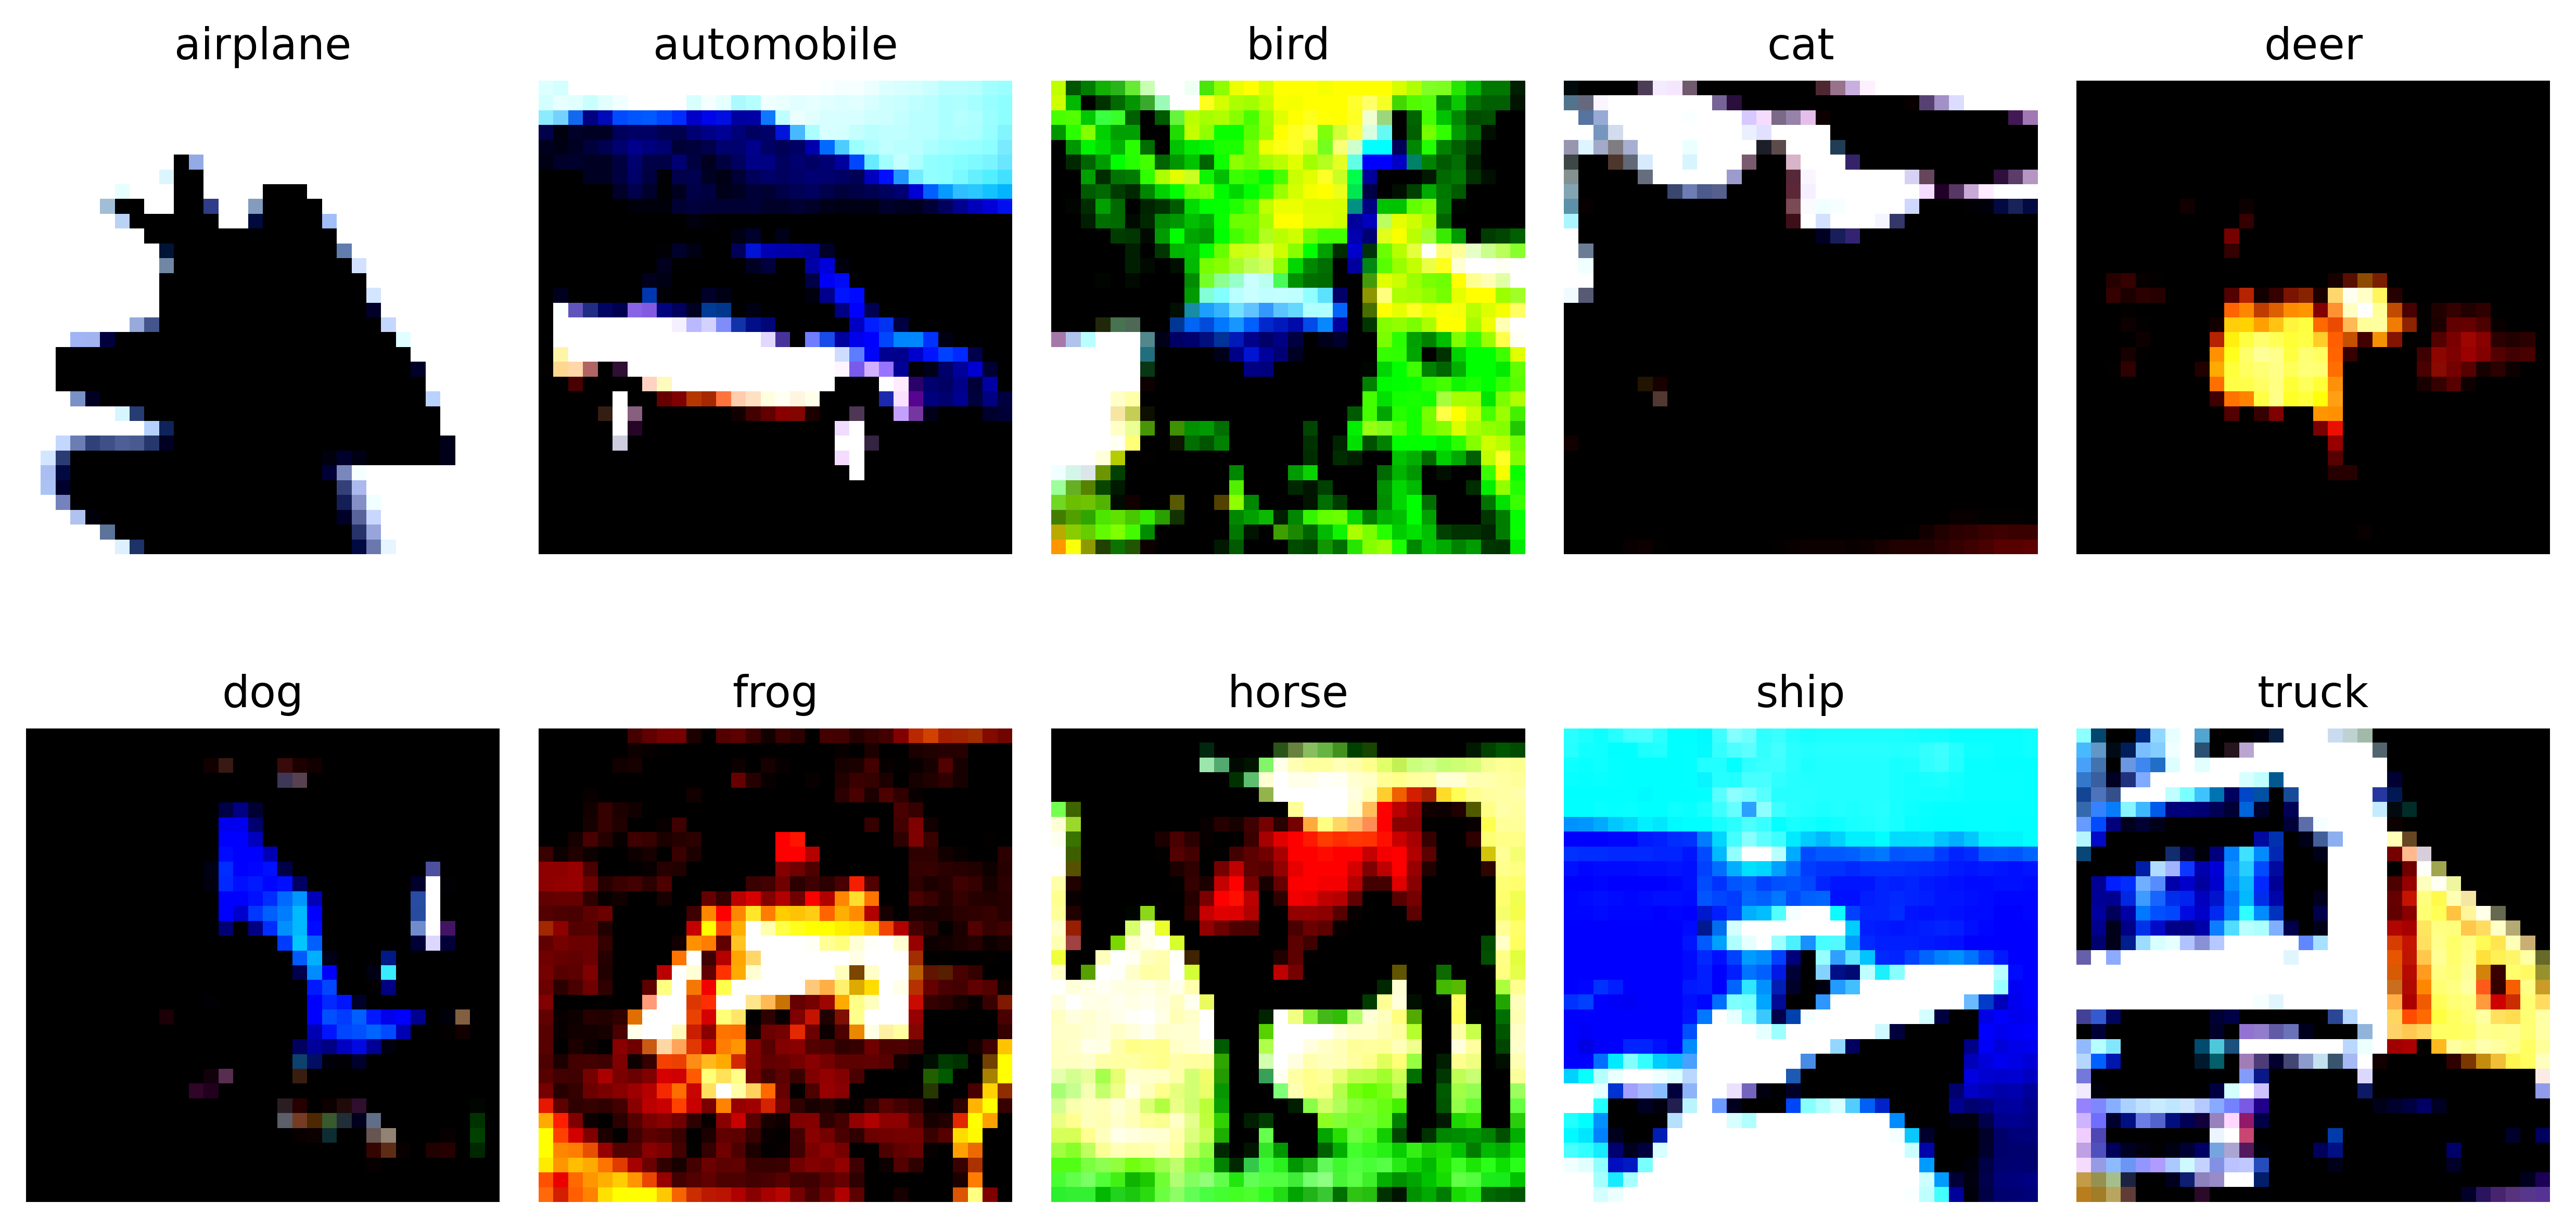

In [6]:
visualize_classes(CLASSES, train_dataset_norm)

Visualization of some samples of the train set with data augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.5000975].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4096808..2.2074432].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..1.8952785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.5967903].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3127563..2.6756902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.293371

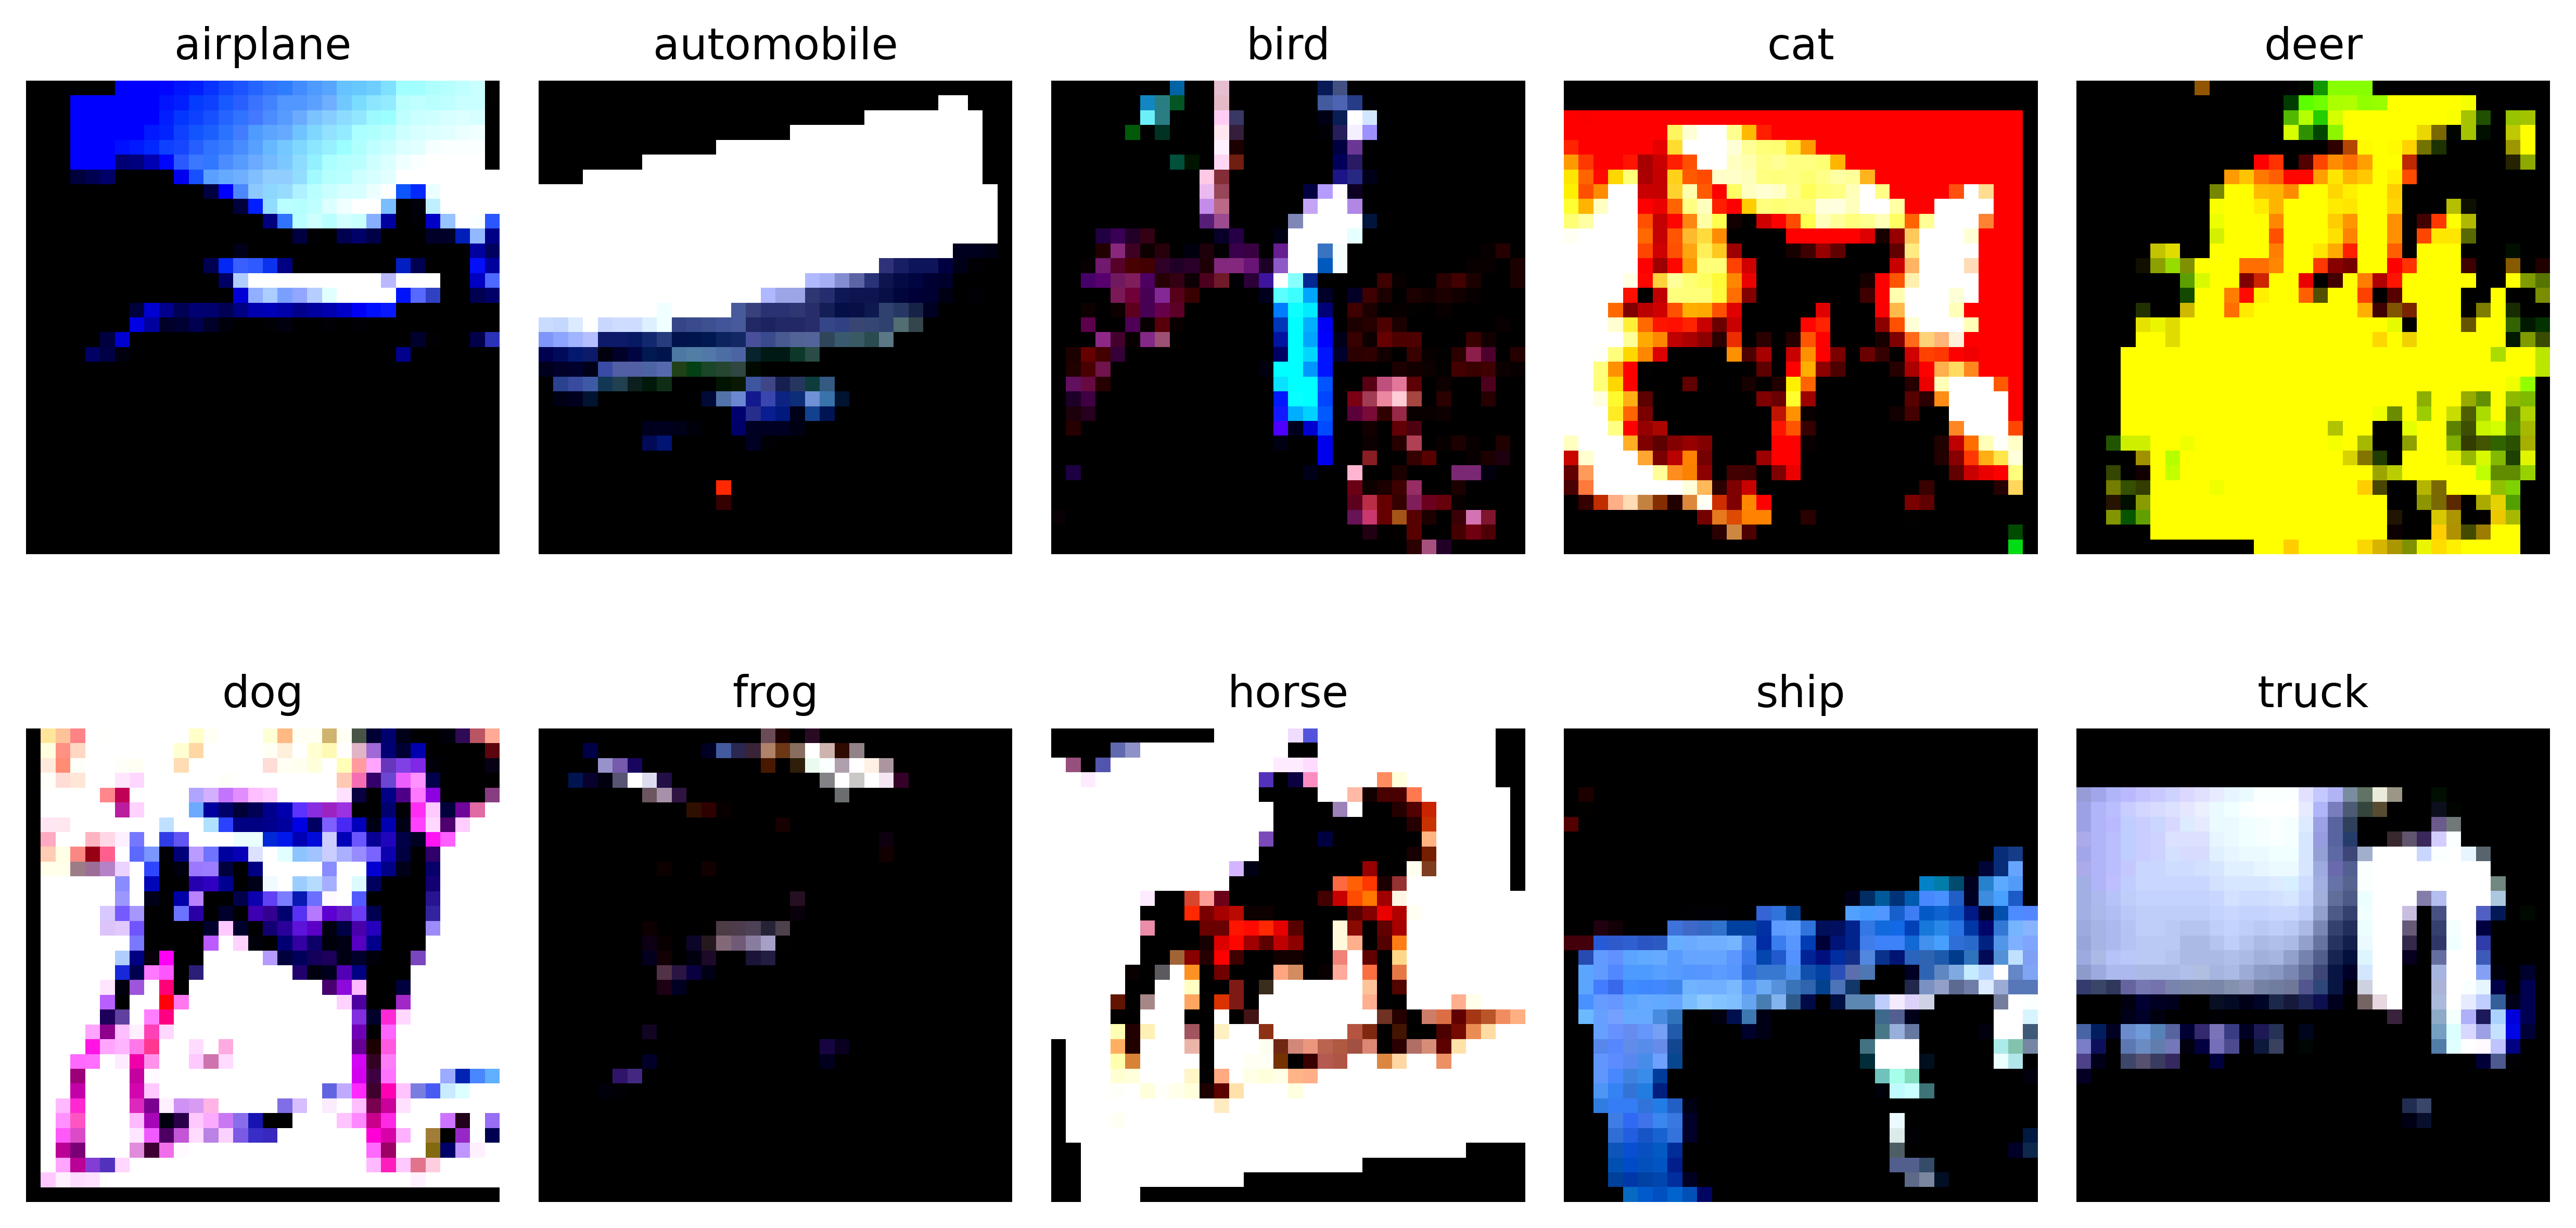

In [7]:
visualize_classes(CLASSES, train_dataset_aug)

## TinyVGG

### Normalized

#### Training

Training phase with selection of best parameters for the TinyVGG model

In [8]:
if TRAIN:
    # Hyperparameter grid
    param_grid = {
        'hidden_units': [32, 64, 128],
        'batch_size': [32, 64, 128]
    }
    param_combinations = list(itertools.product(*param_grid.values()))

    # Results
    results = {}

    # Split the train dataset into training and validation sets
    test_abs = int(len(train_dataset_norm) * 0.8)
    train_subset, val_subset = random_split(
        train_dataset_norm, [test_abs, len(train_dataset_norm) - test_abs]
    )

    best_acc = None

    # Tuning loop
    for hidden_units, batch_size in param_combinations:
        print(f"Tuning: hidden_units={hidden_units}, batch_size={batch_size}")

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=TEST_BATCH_SIZE, shuffle=False)

        model = CIFAR10TinyVGG(3, hidden_units, len(CLASSES)).to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

        train_loss, train_acc, val_loss, val_acc = train(model, optimizer, criterion, train_loader, val_loader, DEVICE, epochs=EPOCHS)
        
        if best_acc is None or max(val_acc) > best_acc:
            best_acc = max(val_acc)

        results[(hidden_units, batch_size)] = max(val_acc)
        print(f"Max Accuracy: {max(val_acc)*100:.2f}%\n")

    best_params = max(results, key=results.get)
    print("==============================")
    print(f"Best config: hidden_units={best_params[0]}, batch_size={best_params[1]}")
    print(f"Accuracy: {results[best_params]*100:.2f}%")
    print("==============================")

Training phase using the best parameters found for TinyVGG

In [9]:
if TRAIN:
    # Split the train dataset into training and validation sets
    test_abs = int(len(train_dataset_norm) * 0.8)
    train_subset, val_subset = random_split(
        train_dataset_norm, [test_abs, len(train_dataset_norm) - test_abs]
    )

    train_loader = DataLoader(train_subset, batch_size=TINY_VGG_BEST_PARAMS['batch_size'], shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=TEST_BATCH_SIZE, shuffle=False)

    model = CIFAR10TinyVGG(3, TINY_VGG_BEST_PARAMS['hidden_units'], len(CLASSES)).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    train_loss_norm, train_acc_norm, val_loss_norm, val_acc_norm = train(model, optimizer, criterion, train_loader, val_loader, DEVICE, epochs=EPOCHS)

    torch.save(model.state_dict(), f"weights/TinyVGG_norm.pth")
    np.savez('results/TinyVGG_norm.npz', train_loss=train_loss_norm, train_acc=train_acc_norm, val_loss=val_loss_norm, val_acc=val_acc_norm)

#### Testing

In [10]:
# Set the model
trained_model = CIFAR10TinyVGG(input_shape=3,
                       hidden_units=TINY_VGG_BEST_PARAMS['hidden_units'],
                       output_shape=len(CLASSES)).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/TinyVGG_norm.pth"))

# Set loss
loss_fn = nn.CrossEntropyLoss()

test_loader = DataLoader(test_dataset_norm, batch_size=TEST_BATCH_SIZE, shuffle=False)

test_time_start_on_gpu = timer()
test(model=trained_model,
    dataloader=test_loader,
    criterion=loss_fn,
    device=DEVICE)
test_time_end_on_gpu = timer()
print_execution_time(start=test_time_start_on_gpu, end=test_time_end_on_gpu, device=DEVICE)

Test loss: 1.081 | Test acc: 75.82%


Execution time on cuda : 3.438 seconds


Prediction visualization

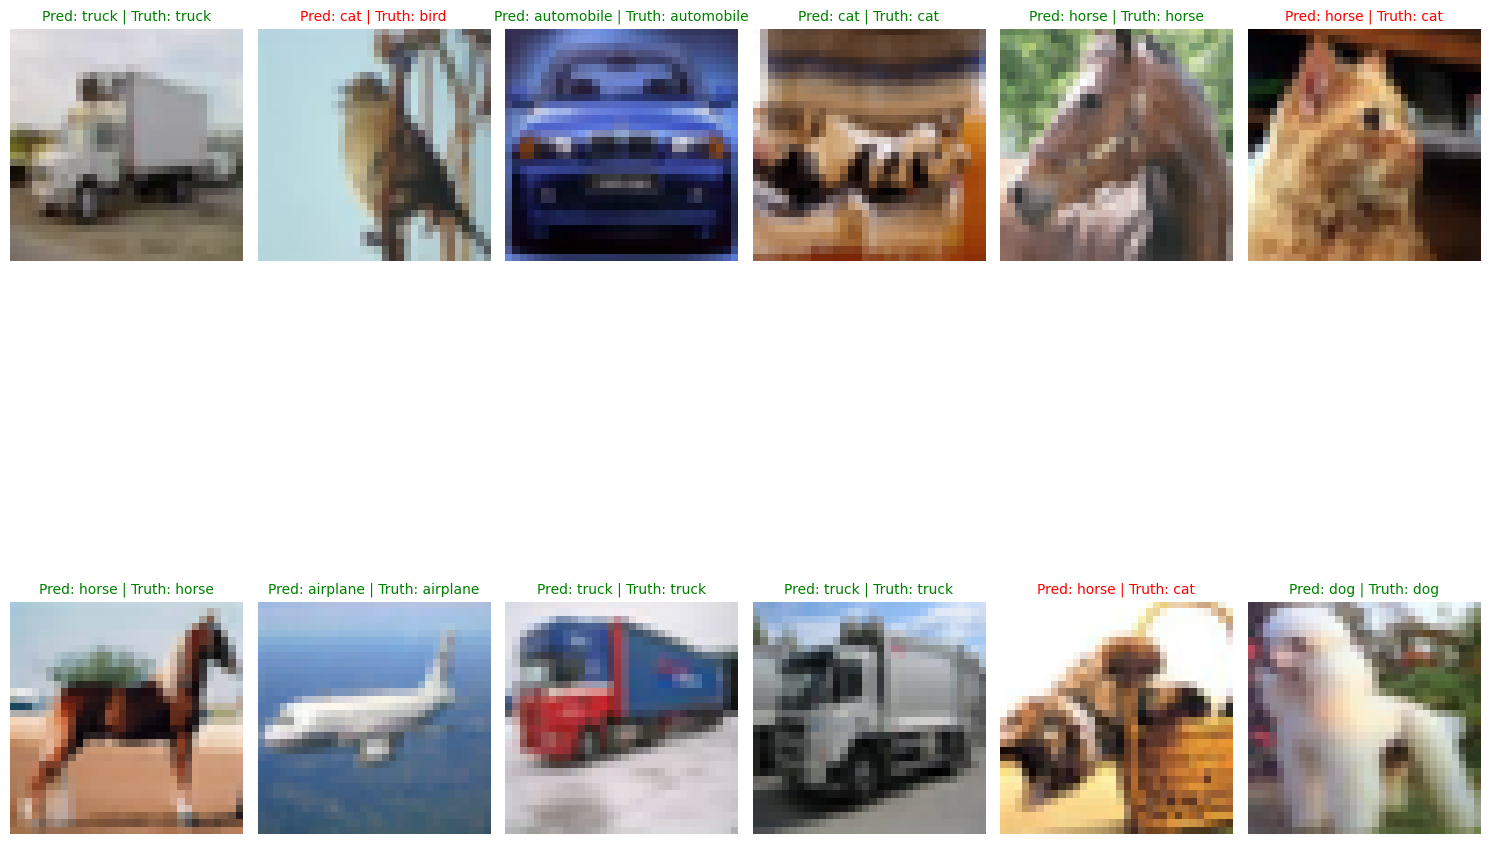

In [11]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset_norm), k=12):
    test_samples.append(sample)
    test_labels.append(label)
pred_probs = make_predictions(model=trained_model, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

# Plot predictions
plt.figure(figsize=(15, 15))
nrows = 2
ncols = 6
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    sample = (sample * STD[:, None, None] + MEAN[:, None, None]).clamp(0, 1)
    plt.imshow(sample.permute(1, 2, 0))

    # FInd the prediction (in text form, e.g. "Sandal")
    pred_label = CLASSES[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = CLASSES[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
    else:
        plt.title(title_text, fontsize=10, c="r")

    plt.axis(False)
plt.tight_layout()
plt.show()

Confusion Matrix

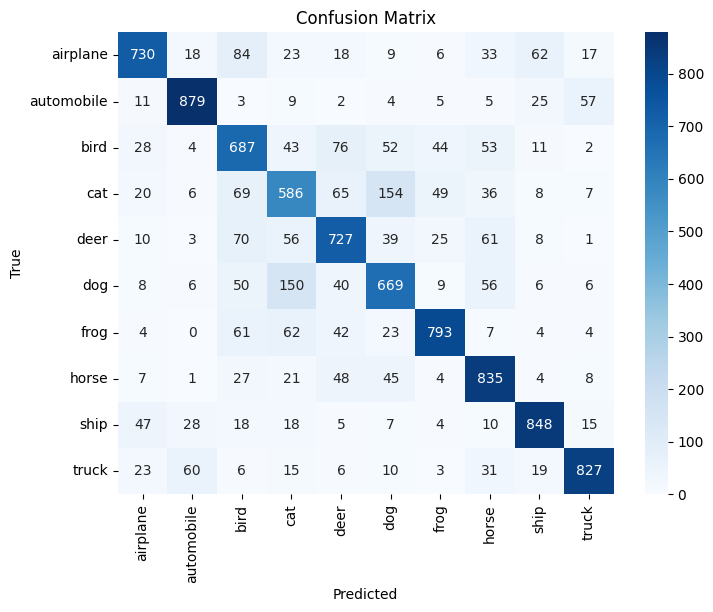

In [8]:
# Set the model
trained_model = CIFAR10TinyVGG(input_shape=3,
                       hidden_units=TINY_VGG_BEST_PARAMS['hidden_units'],
                       output_shape=len(CLASSES)).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/TinyVGG_norm.pth"))

test_loader = DataLoader(test_dataset_norm, batch_size=TEST_BATCH_SIZE, shuffle=False)

confusion_matrix_plot(trained_model, test_loader, CLASSES, DEVICE)

### With Data Augmentation

#### Training 

Training phase using the best parameters found for TinyVGG

In [12]:
if TRAIN:
    train_loader = DataLoader(train_dataset_aug, batch_size=TINY_VGG_BEST_PARAMS['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset_aug, batch_size=TEST_BATCH_SIZE, shuffle=False)

    model = CIFAR10TinyVGG(3, TINY_VGG_BEST_PARAMS['hidden_units'], len(CLASSES)).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    train_loss_aug, train_acc_aug, val_loss_aug, val_acc_aug = train(model, optimizer, criterion, train_loader, val_loader, DEVICE, epochs=EPOCHS)

    torch.save(model.state_dict(), f"weights/TinyVGG_aug.pth")
    np.savez('results/TinyVGG_aug.npz', train_loss=train_loss_aug, train_acc=train_acc_aug, val_loss=val_loss_aug, val_acc=val_acc_aug)

#### Testing

In [13]:
# Set the model
trained_model = CIFAR10TinyVGG(input_shape=3,
                       hidden_units=TINY_VGG_BEST_PARAMS['hidden_units'],
                       output_shape=len(CLASSES)).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/TinyVGG_aug.pth"))

# Set loss
loss_fn = nn.CrossEntropyLoss()

test_loader = DataLoader(test_dataset_aug, batch_size=TEST_BATCH_SIZE, shuffle=False)

test_time_start_on_gpu = timer()
test(model=trained_model,
    dataloader=test_loader,
    criterion=loss_fn,
    device=DEVICE)
test_time_end_on_gpu = timer()
print_execution_time(start=test_time_start_on_gpu, end=test_time_end_on_gpu, device=DEVICE)

Test loss: 0.568 | Test acc: 81.09%


Execution time on cuda : 3.251 seconds


Prediction visualization

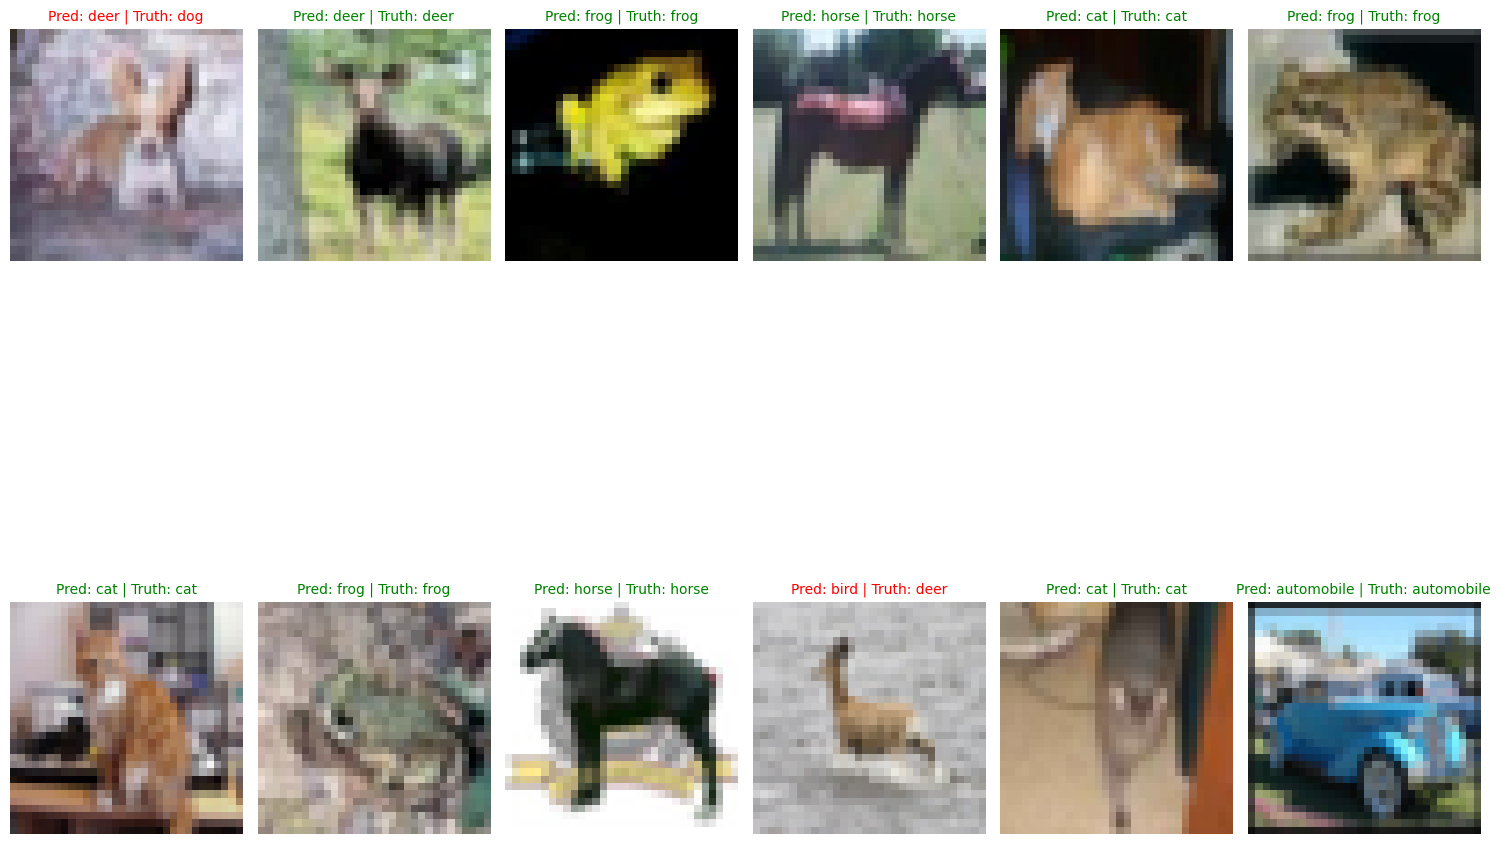

In [14]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset_aug), k=12):
    test_samples.append(sample)
    test_labels.append(label)
pred_probs = make_predictions(model=trained_model, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

# Plot predictions
plt.figure(figsize=(15, 15))
nrows = 2
ncols = 6
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    sample = (sample * STD[:, None, None] + MEAN[:, None, None]).clamp(0, 1)
    plt.imshow(sample.permute(1, 2, 0))

    # FInd the prediction (in text form, e.g. "Sandal")
    pred_label = CLASSES[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = CLASSES[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
    else:
        plt.title(title_text, fontsize=10, c="r")

    plt.axis(False)
plt.tight_layout()
plt.show()

Confusion Matrix

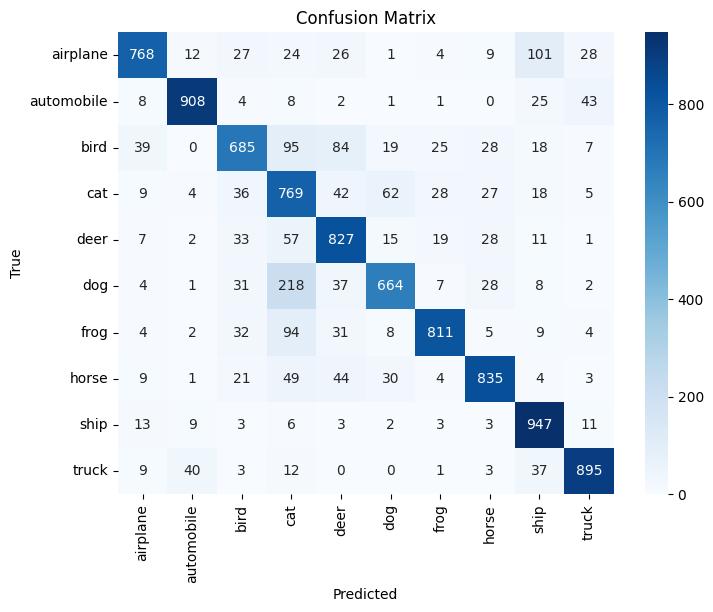

In [9]:
# Set the model
trained_model = CIFAR10TinyVGG(input_shape=3,
                       hidden_units=TINY_VGG_BEST_PARAMS['hidden_units'],
                       output_shape=len(CLASSES)).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/TinyVGG_aug.pth"))

test_loader = DataLoader(test_dataset_norm, batch_size=TEST_BATCH_SIZE, shuffle=False)

confusion_matrix_plot(trained_model, test_loader, CLASSES, DEVICE)

### Comparison
Plot of the results obained during the training with normalization and data augmentation

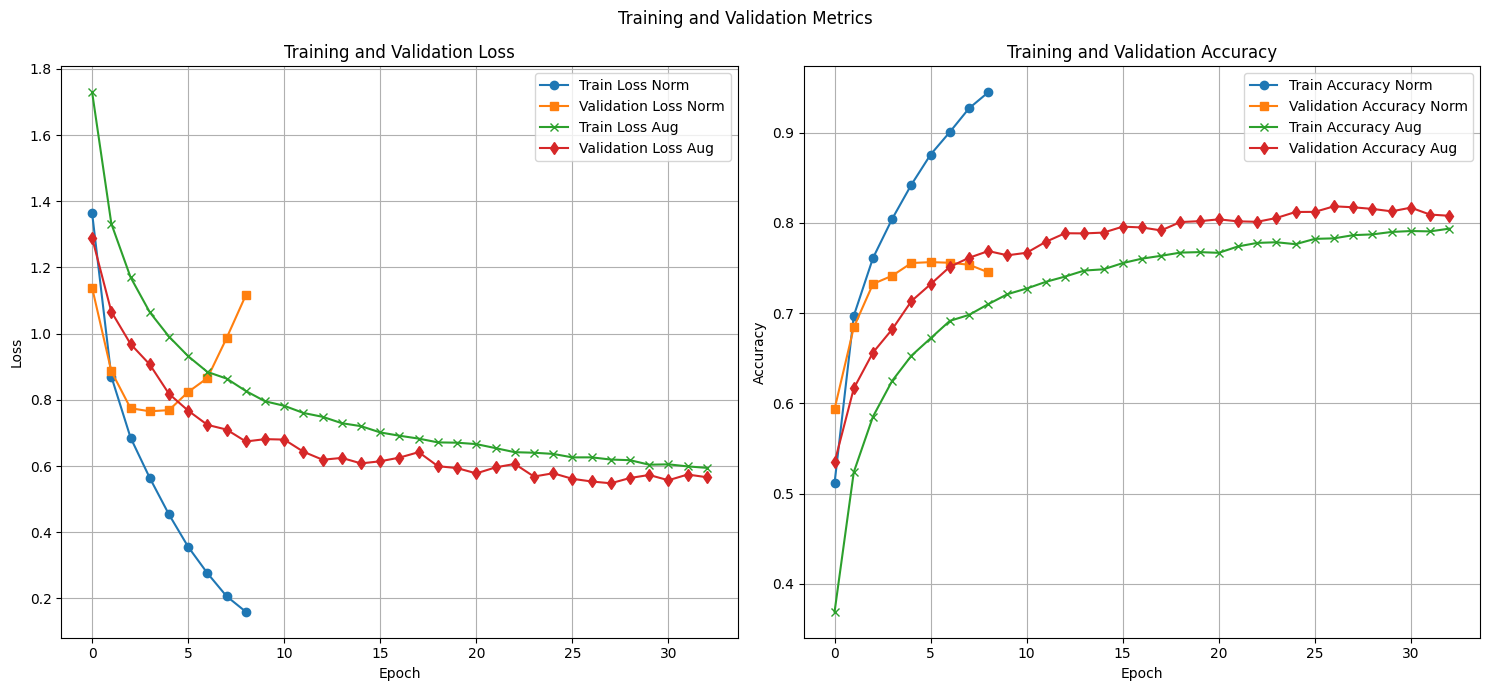

In [15]:
plot_results('results/TinyVGG_norm.npz', 'results/TinyVGG_aug.npz')

## ResNet-12

### Normalized

#### Training

Training phase with selection of best parameters for the ResNet-12 model

In [16]:
if TRAIN:
    # Hyperparameter grid
    param_grid = {
        'hidden_units': [32, 64, 128],
        'batch_size': [32, 64, 128]
    }
    param_combinations = list(itertools.product(*param_grid.values()))

    # Results
    results = {}

    # Split the train dataset into training and validation sets
    test_abs = int(len(train_dataset_norm) * 0.8)
    train_subset, val_subset = random_split(
        train_dataset_norm, [test_abs, len(train_dataset_norm) - test_abs]
    )

    best_acc = None

    # Tuning loop
    for hidden_units, batch_size in param_combinations:
        print(f"Tuning: hidden_units={hidden_units}, batch_size={batch_size}")

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=TEST_BATCH_SIZE, shuffle=False)

        model = CIFAR10ResNet12(3, hidden_units, len(CLASSES)).to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

        train_loss, train_acc, val_loss, val_acc = train(model, optimizer, criterion, train_loader, val_loader, DEVICE, epochs=EPOCHS)
        
        if best_acc is None or max(val_acc) > best_acc:
            best_acc = max(val_acc)

        results[(hidden_units, batch_size)] = max(val_acc)
        print(f"Max Accuracy: {max(val_acc)*100:.2f}%\n")

    best_params = max(results, key=results.get)
    print("==============================")
    print(f"Best config: hidden_units={best_params[0]}, batch_size={best_params[1]}")
    print(f"Accuracy: {results[best_params]*100:.2f}%")
    print("==============================")

Training phase using the best parameters found for ResNet-12

In [17]:
if TRAIN:
    # Split the train dataset into training and validation sets
    test_abs = int(len(train_dataset_norm) * 0.8)
    train_subset, val_subset = random_split(
        train_dataset_norm, [test_abs, len(train_dataset_norm) - test_abs]
    )

    train_loader = DataLoader(train_subset, batch_size=RESNET_BEST_PARAMS['batch_size'], shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=TEST_BATCH_SIZE, shuffle=False)

    model = CIFAR10ResNet12(3, RESNET_BEST_PARAMS['hidden_units'], len(CLASSES)).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    train_loss_norm, train_acc_norm, val_loss_norm, val_acc_norm = train(model, optimizer, criterion, train_loader, val_loader, DEVICE, epochs=EPOCHS)

    torch.save(model.state_dict(), f"weights/ResNet12_norm.pth")
    np.savez('results/ResNet12_norm.npz', train_loss=train_loss_norm, train_acc=train_acc_norm, val_loss=val_loss_norm, val_acc=val_acc_norm)

#### Testing

In [18]:
# Set the model
trained_model = CIFAR10ResNet12(input_shape=3,
                       hidden_units=RESNET_BEST_PARAMS['hidden_units'],
                       output_shape=len(CLASSES)).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/ResNet12_norm.pth"))

# Set loss
loss_fn = nn.CrossEntropyLoss()

test_loader = DataLoader(test_dataset_norm, batch_size=TEST_BATCH_SIZE, shuffle=False)

test_time_start_on_gpu = timer()
test(model=trained_model,
    dataloader=test_loader,
    criterion=loss_fn,
    device=DEVICE)
test_time_end_on_gpu = timer()
print_execution_time(start=test_time_start_on_gpu, end=test_time_end_on_gpu, device=DEVICE)

Test loss: 0.629 | Test acc: 84.57%


Execution time on cuda : 8.165 seconds


Prediction visualization

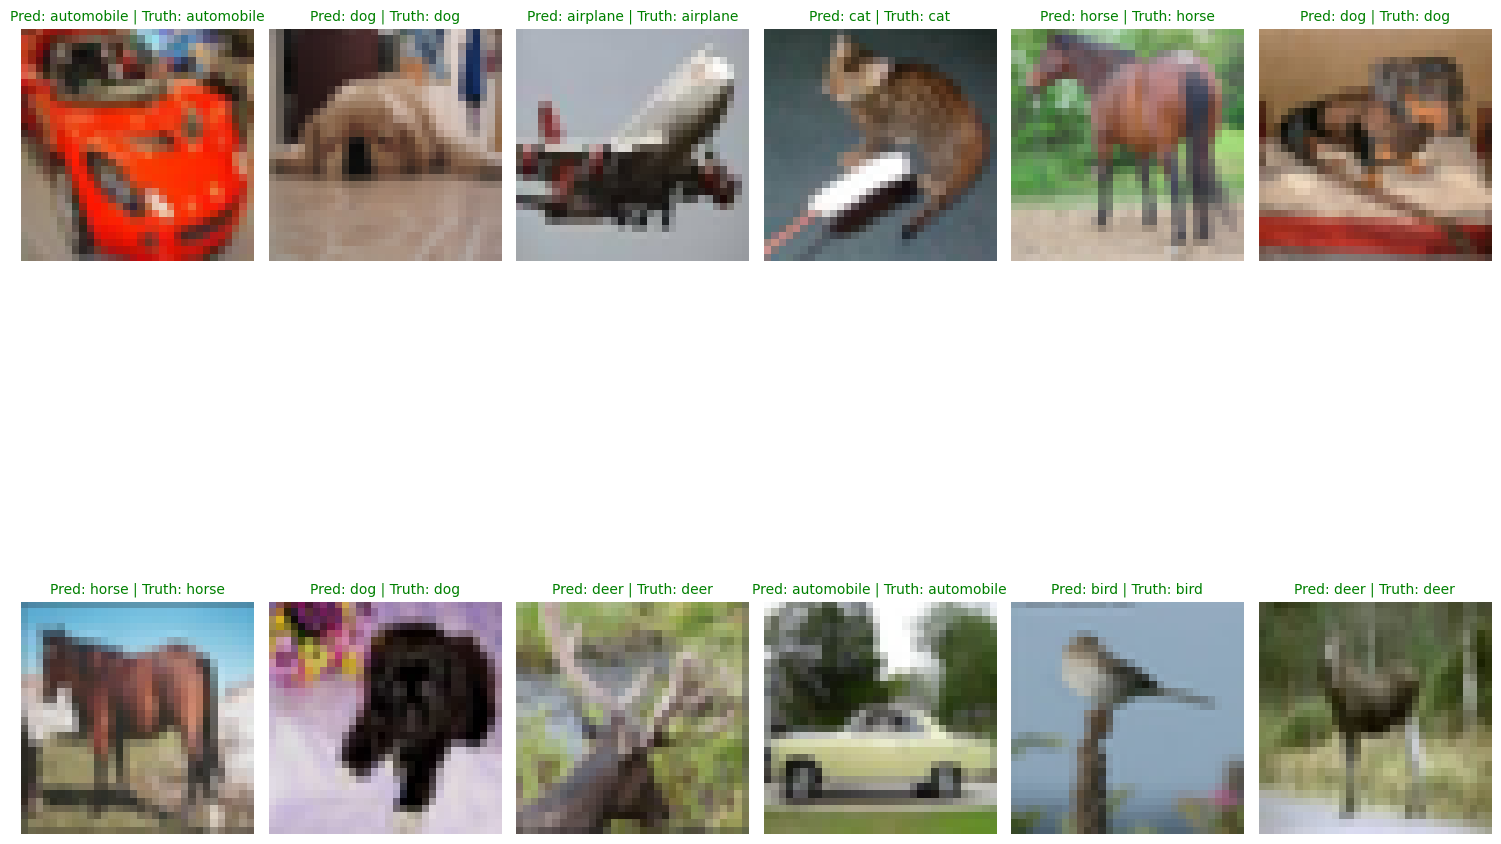

In [19]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset_norm), k=12):
    test_samples.append(sample)
    test_labels.append(label)
pred_probs = make_predictions(model=trained_model, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

# Plot predictions
plt.figure(figsize=(15, 15))
nrows = 2
ncols = 6
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    sample = (sample * STD[:, None, None] + MEAN[:, None, None]).clamp(0, 1)
    plt.imshow(sample.permute(1, 2, 0))

    pred_label = CLASSES[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = CLASSES[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
    else:
        plt.title(title_text, fontsize=10, c="r")

    plt.axis(False)
plt.tight_layout()
plt.show()

Confusion Matrix

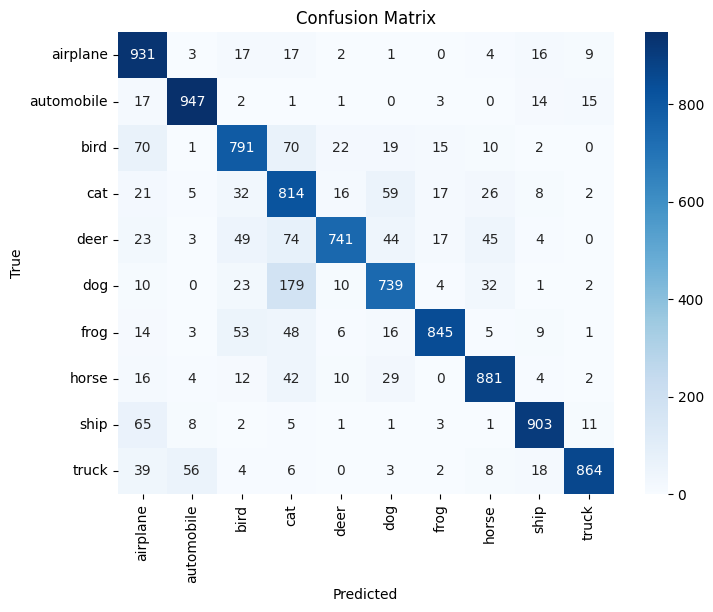

In [10]:
# Set the model
trained_model = CIFAR10ResNet12(input_shape=3,
                       hidden_units=RESNET_BEST_PARAMS['hidden_units'],
                       output_shape=len(CLASSES)).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/ResNet12_norm.pth"))

test_loader = DataLoader(test_dataset_norm, batch_size=TEST_BATCH_SIZE, shuffle=False)

confusion_matrix_plot(trained_model, test_loader, CLASSES, DEVICE)

### With Data Augmentation

#### Training

Training phase using the best parameters found for ResNet-12

In [20]:
if TRAIN:
    train_loader = DataLoader(train_dataset_aug, batch_size=RESNET_BEST_PARAMS['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset_aug, batch_size=TEST_BATCH_SIZE, shuffle=False)

    model = CIFAR10ResNet12(3, RESNET_BEST_PARAMS['hidden_units'], len(CLASSES)).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    train_loss_norm, train_acc_norm, val_loss_norm, val_acc_norm = train(model, optimizer, criterion, train_loader, val_loader, DEVICE, epochs=EPOCHS)

    torch.save(model.state_dict(), f"weights/ResNet12_aug.pth")
    np.savez('results/ResNet12_aug.npz', train_loss=train_loss_norm, train_acc=train_acc_norm, val_loss=val_loss_norm, val_acc=val_acc_norm)

#### Testing

In [21]:
# Set the model
trained_model = CIFAR10ResNet12(input_shape=3,
                       hidden_units=RESNET_BEST_PARAMS['hidden_units'],
                       output_shape=len(CLASSES)).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/ResNet12_aug.pth"))

# Set loss
loss_fn = nn.CrossEntropyLoss()

test_loader = DataLoader(test_dataset_aug, batch_size=TEST_BATCH_SIZE, shuffle=False)

test_time_start_on_gpu = timer()
test(model=trained_model,
    dataloader=test_loader,
    criterion=loss_fn,
    device=DEVICE)
test_time_end_on_gpu = timer()
print_execution_time(start=test_time_start_on_gpu, end=test_time_end_on_gpu, device=DEVICE)

Test loss: 0.340 | Test acc: 89.81%


Execution time on cuda : 8.086 seconds


Prediction visualization

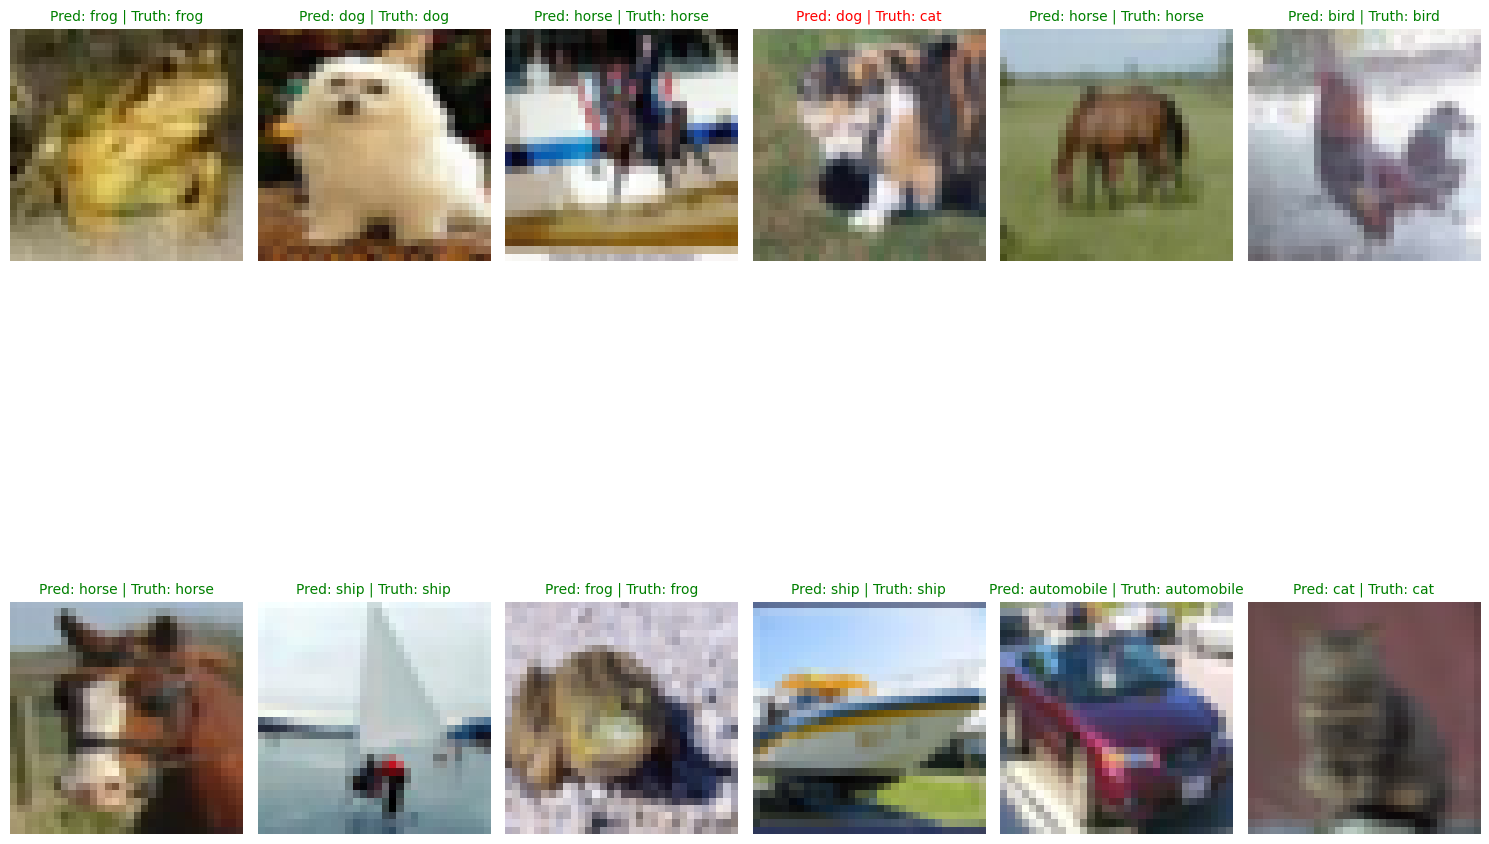

In [22]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset_aug), k=12):
    test_samples.append(sample)
    test_labels.append(label)
pred_probs = make_predictions(model=trained_model, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

# Plot predictions
plt.figure(figsize=(15, 15))
nrows = 2
ncols = 6
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    sample = (sample * STD[:, None, None] + MEAN[:, None, None]).clamp(0, 1)
    plt.imshow(sample.permute(1, 2, 0))

    pred_label = CLASSES[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = CLASSES[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
    else:
        plt.title(title_text, fontsize=10, c="r")

    plt.axis(False)
plt.tight_layout()
plt.show()

Confusion Matrix

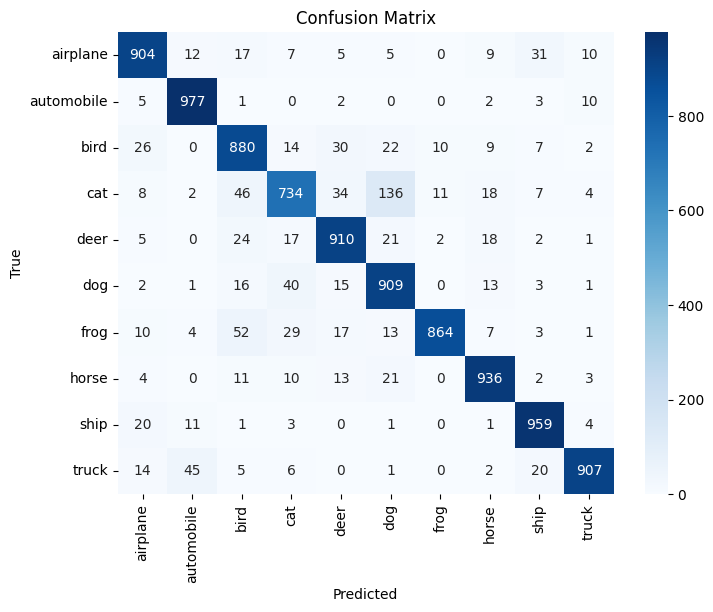

In [11]:
# Set the model
trained_model = CIFAR10ResNet12(input_shape=3,
                       hidden_units=RESNET_BEST_PARAMS['hidden_units'],
                       output_shape=len(CLASSES)).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/ResNet12_aug.pth"))

test_loader = DataLoader(test_dataset_norm, batch_size=TEST_BATCH_SIZE, shuffle=False)

confusion_matrix_plot(trained_model, test_loader, CLASSES, DEVICE)

### Comparison
Plot of the results obained during the training with normalization and data augmentation

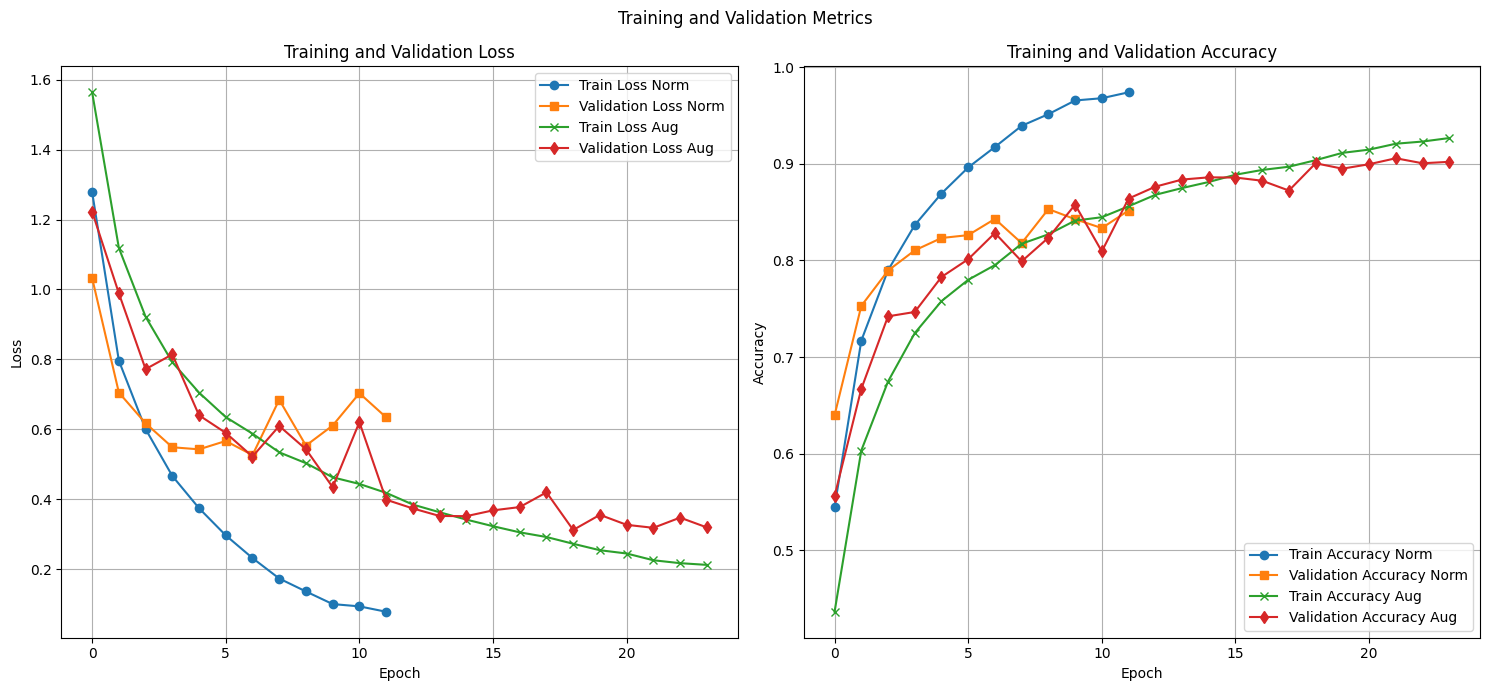

In [23]:
plot_results('results/ResNet12_norm.npz', 'results/ResNet12_aug.npz')

## GRU

### Normalized

#### Training

Training phase with selection of best parameters for the GRU model

In [24]:
if TRAIN:
    # Hyperparameter grid
    param_grid = {
        'hidden_units': [32, 64, 128],
        'num_layers': [1, 2, 3, 4],
        'batch_size': [32, 64, 128]
    }
    param_combinations = list(itertools.product(*param_grid.values()))

    # Results
    results = {}

    # Split the train dataset into training and validation sets
    test_abs = int(len(train_dataset_norm) * 0.8)
    train_subset, val_subset = random_split(
        train_dataset_norm, [test_abs, len(train_dataset_norm) - test_abs]
    )

    best_acc = None

    # Tuning loop
    for hidden_units, num_layers, batch_size in param_combinations:
        print(f"Tuning: hidden_units={hidden_units}, num_layers={num_layers}, batch_size={batch_size}")

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=TEST_BATCH_SIZE, shuffle=False)

        model = CIFAR10RNN(3, hidden_units, num_layers, len(CLASSES)).to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

        train_loss, train_acc, val_loss, val_acc = train(model, optimizer, criterion, train_loader, val_loader, DEVICE, epochs=EPOCHS)
        
        if best_acc is None or max(val_acc) > best_acc:
            best_acc = max(val_acc)

        results[(hidden_units, num_layers, batch_size)] = max(val_acc)
        print(f"Max Accuracy: {max(val_acc)*100:.2f}%\n")

    best_params = max(results, key=results.get)
    print("==============================")
    print(f"Best config: hidden_units={best_params[0]}, num_layers={best_params[1]}, batch_size={best_params[2]}")
    print(f"Accuracy: {results[best_params]*100:.2f}%")
    print("==============================")

Training phase using the best parameters found for GRU

In [25]:
if TRAIN:
    # Split the train dataset into training and validation sets
    test_abs = int(len(train_dataset_norm) * 0.8)
    train_subset, val_subset = random_split(
        train_dataset_norm, [test_abs, len(train_dataset_norm) - test_abs]
    )

    train_loader = DataLoader(train_subset, batch_size=GRU_BEST_PARAMS['batch_size'], shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=TEST_BATCH_SIZE, shuffle=False)

    model = CIFAR10RNN(3, GRU_BEST_PARAMS['hidden_units'], GRU_BEST_PARAMS['num_layers'], len(CLASSES)).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    train_loss_norm, train_acc_norm, val_loss_norm, val_acc_norm = train(model, optimizer, criterion, train_loader, val_loader, DEVICE, epochs=EPOCHS)

    torch.save(model.state_dict(), f"weights/GRU_norm.pth")
    np.savez('results/GRU_norm.npz', train_loss=train_loss_norm, train_acc=train_acc_norm, val_loss=val_loss_norm, val_acc=val_acc_norm)

#### Testing

In [26]:
# Set the model
trained_model = CIFAR10RNN(3, GRU_BEST_PARAMS['hidden_units'], GRU_BEST_PARAMS['num_layers'], len(CLASSES)).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/GRU_norm.pth"))

# Set loss
loss_fn = nn.CrossEntropyLoss()

test_loader = DataLoader(test_dataset_norm, batch_size=TEST_BATCH_SIZE, shuffle=False)

test_time_start_on_gpu = timer()
test(model=trained_model,
    dataloader=test_loader,
    criterion=loss_fn,
    device=DEVICE)
test_time_end_on_gpu = timer()
print_execution_time(start=test_time_start_on_gpu, end=test_time_end_on_gpu, device=DEVICE)

Test loss: 1.033 | Test acc: 68.44%


Execution time on cuda : 6.808 seconds


Prediction visualization

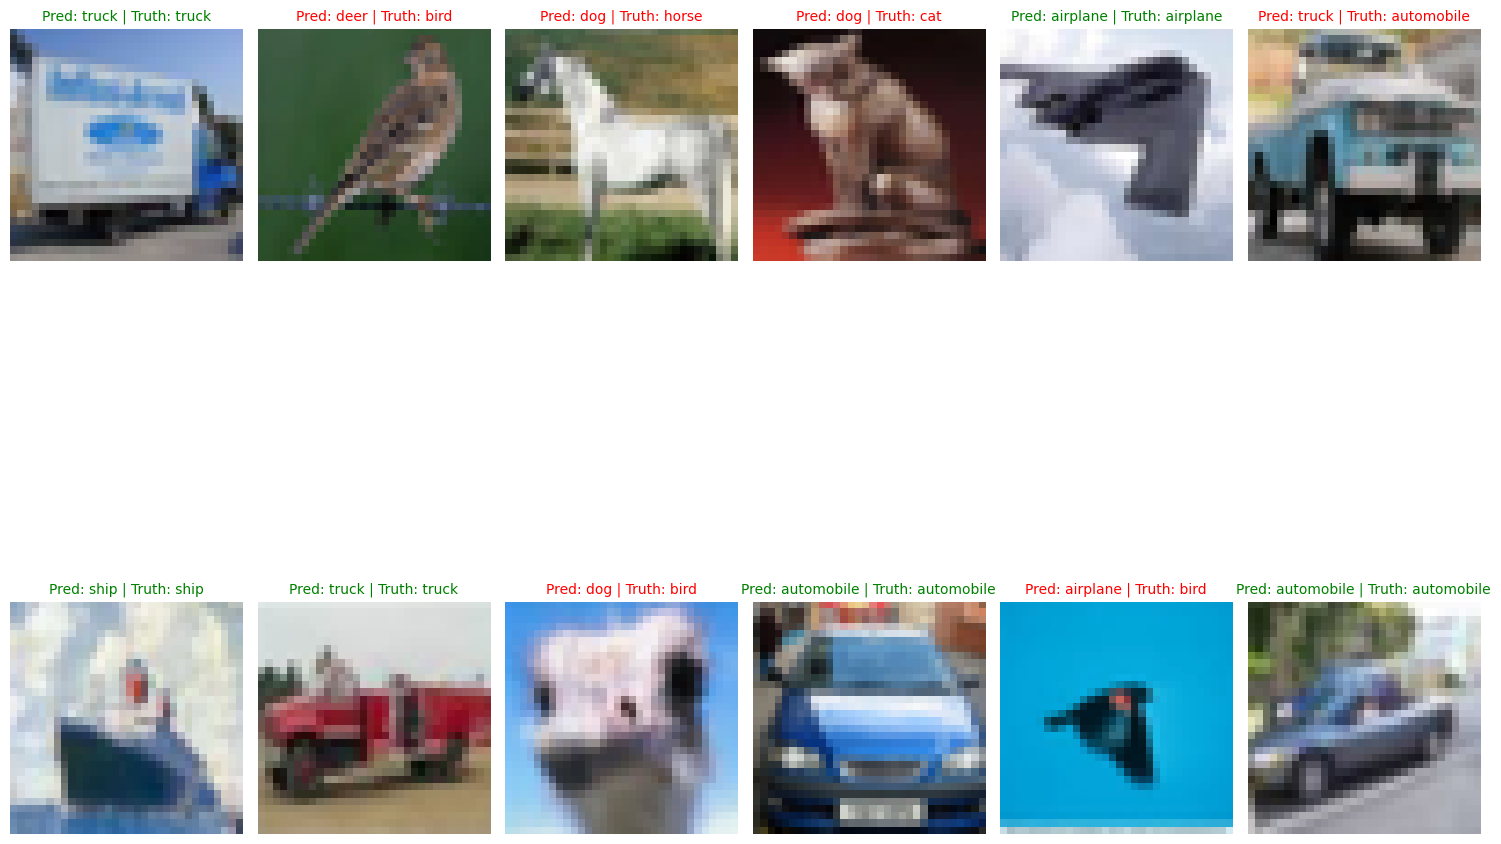

In [27]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset_norm), k=12):
    test_samples.append(sample)
    test_labels.append(label)
pred_probs = make_predictions(model=trained_model, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

# Plot predictions
plt.figure(figsize=(15, 15))
nrows = 2
ncols = 6
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    sample = (sample * STD[:, None, None] + MEAN[:, None, None]).clamp(0, 1)
    plt.imshow(sample.permute(1, 2, 0))

    pred_label = CLASSES[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = CLASSES[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
    else:
        plt.title(title_text, fontsize=10, c="r")

    plt.axis(False)
plt.tight_layout()
plt.show()

Confusion Matrix

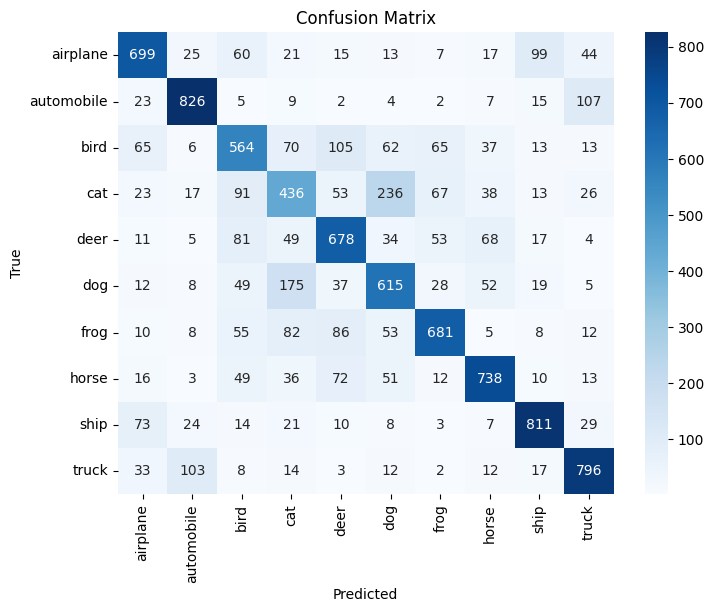

In [12]:
# Set the model
trained_model = CIFAR10RNN(3, GRU_BEST_PARAMS['hidden_units'], GRU_BEST_PARAMS['num_layers'], len(CLASSES)).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/GRU_norm.pth"))

test_loader = DataLoader(test_dataset_norm, batch_size=TEST_BATCH_SIZE, shuffle=False)

confusion_matrix_plot(trained_model, test_loader, CLASSES, DEVICE)

### With Data Augmentation

#### Training

Training phase using the best parameters found for GRU

In [28]:
if TRAIN:
    train_loader = DataLoader(train_dataset_aug, batch_size=GRU_BEST_PARAMS['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset_aug, batch_size=TEST_BATCH_SIZE, shuffle=False)

    model = CIFAR10RNN(3, GRU_BEST_PARAMS['hidden_units'], GRU_BEST_PARAMS['num_layers'], len(CLASSES)).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    train_loss_norm, train_acc_norm, val_loss_norm, val_acc_norm = train(model, optimizer, criterion, train_loader, val_loader, DEVICE, epochs=EPOCHS)

    torch.save(model.state_dict(), f"weights/GRU_aug.pth")
    np.savez('results/GRU_aug.npz', train_loss=train_loss_norm, train_acc=train_acc_norm, val_loss=val_loss_norm, val_acc=val_acc_norm)

#### Testing

In [29]:
# Set the model
trained_model = CIFAR10RNN(3, GRU_BEST_PARAMS['hidden_units'], GRU_BEST_PARAMS['num_layers'], len(CLASSES)).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/GRU_aug.pth"))

# Set loss
loss_fn = nn.CrossEntropyLoss()

test_loader = DataLoader(test_dataset_norm, batch_size=TEST_BATCH_SIZE, shuffle=False)

test_time_start_on_gpu = timer()
test(model=trained_model,
    dataloader=test_loader,
    criterion=loss_fn,
    device=DEVICE)
test_time_end_on_gpu = timer()
print_execution_time(start=test_time_start_on_gpu, end=test_time_end_on_gpu, device=DEVICE)

Test loss: 0.845 | Test acc: 71.47%


Execution time on cuda : 7.031 seconds


Prediction visualization

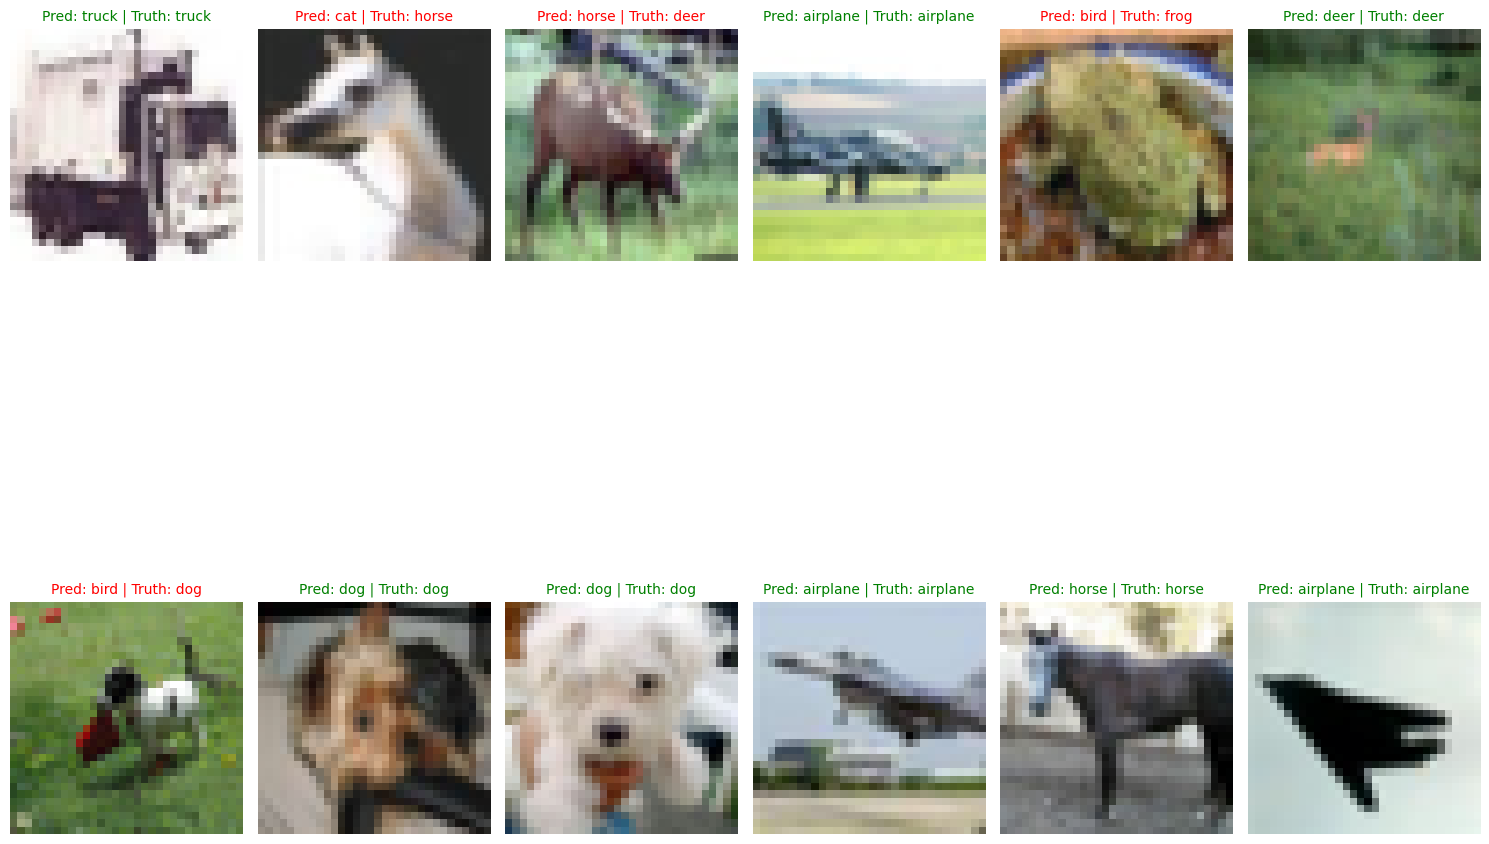

In [30]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset_norm), k=12):
    test_samples.append(sample)
    test_labels.append(label)
pred_probs = make_predictions(model=trained_model, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

# Plot predictions
plt.figure(figsize=(15, 15))
nrows = 2
ncols = 6
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    sample = (sample * STD[:, None, None] + MEAN[:, None, None]).clamp(0, 1)
    plt.imshow(sample.permute(1, 2, 0))

    pred_label = CLASSES[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = CLASSES[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
    else:
        plt.title(title_text, fontsize=10, c="r")

    plt.axis(False)
plt.tight_layout()
plt.show()

Confusion Matrix

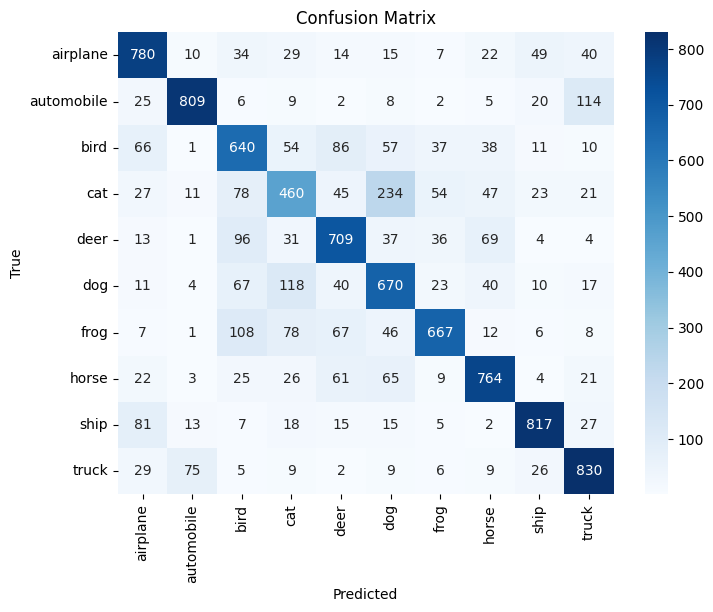

In [13]:
# Set the model
trained_model = CIFAR10RNN(3, GRU_BEST_PARAMS['hidden_units'], GRU_BEST_PARAMS['num_layers'], len(CLASSES)).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/GRU_aug.pth"))

test_loader = DataLoader(test_dataset_norm, batch_size=TEST_BATCH_SIZE, shuffle=False)

confusion_matrix_plot(trained_model, test_loader, CLASSES, DEVICE)

### Comparison
Plot of the results obained during the training with normalization and data augmentation

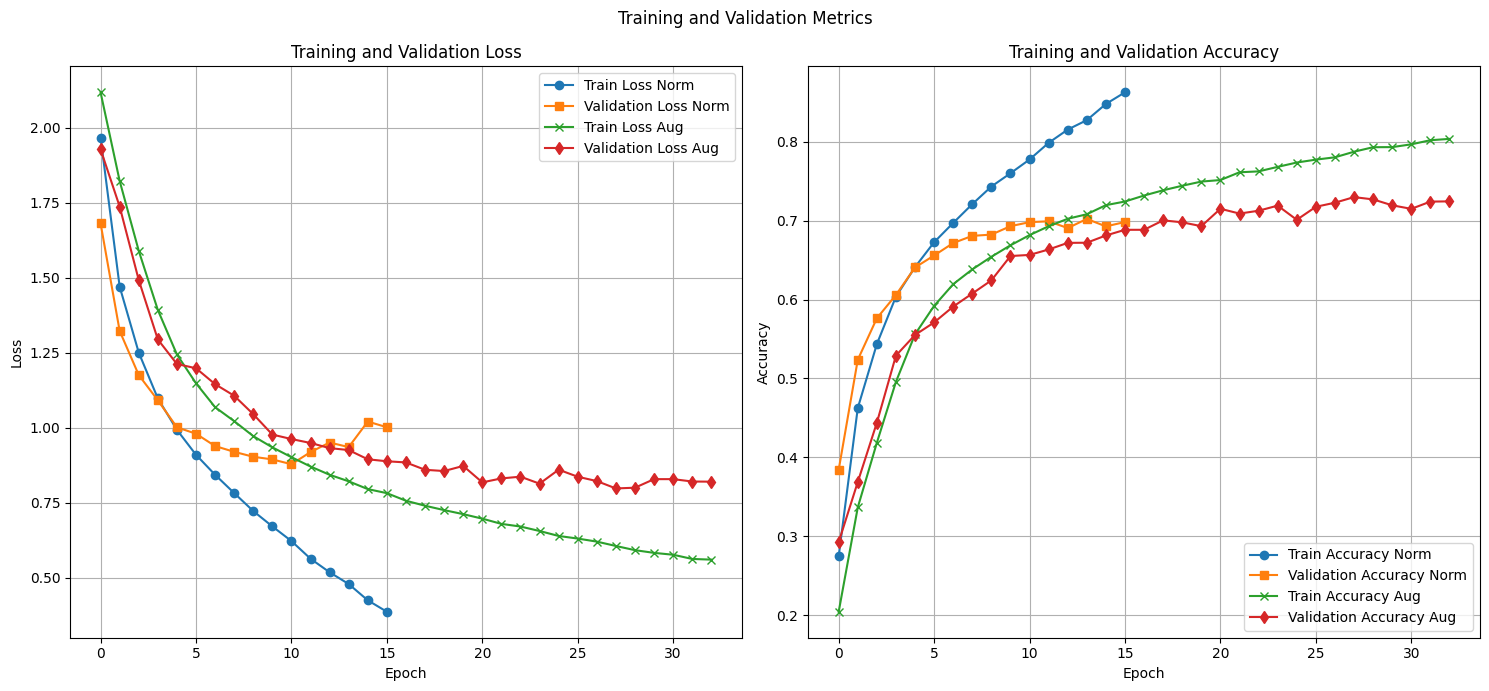

In [31]:
plot_results('results/GRU_norm.npz', 'results/GRU_aug.npz')

## Vision Transformer

### Normalized

#### Training

Training phase with selection of best parameters for the Vision Transformer model

In [32]:
if TRAIN:
    # Hyperparameter grid
    param_grid = {
        'embed_dim': [32, 64, 128],
        'depth': [4, 6, 8],
        'mlp_dim': [128, 256, 512],
        'batch_size': [32, 64, 128]
    }
    param_combinations = list(itertools.product(*param_grid.values()))

    # Results
    results = {}

    # Split the train dataset into training and validation sets
    test_abs = int(len(train_dataset_norm) * 0.8)
    train_subset, val_subset = random_split(
        train_dataset_norm, [test_abs, len(train_dataset_norm) - test_abs]
    )

    best_acc = None

    # Tuning loop
    for embed_dim, depth, mlp_dim, batch_size in param_combinations:
        print(f"Tuning: embed_dim={embed_dim}, depth={depth}, mlp_dim={mlp_dim}, batch_size={batch_size}")

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=TEST_BATCH_SIZE, shuffle=False)

        model = CIFAR10VisionTransformer(img_size=32, patch_size=4, in_channels=3, num_classes=len(CLASSES), embed_dim=embed_dim, depth=depth, num_heads=8, mlp_dim=mlp_dim, dropout=0.1).to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

        train_loss, train_acc, val_loss, val_acc = train(model, optimizer, criterion, train_loader, val_loader, DEVICE, epochs=EPOCHS)
        
        if best_acc is None or max(val_acc) > best_acc:
            best_acc = max(val_acc)

        results[(embed_dim, depth, mlp_dim, batch_size)] = max(val_acc)
        print(f"Max Accuracy: {max(val_acc)*100:.2f}%\n")

    best_params = max(results, key=results.get)
    print("==============================")
    print(f"Best config: embed_dim={best_params[0]}, depth={best_params[1]}, mlp_dim={best_params[2]}, batch_size={best_params[3]}")
    print(f"Accuracy: {results[best_params]*100:.2f}%")
    print("==============================")

Training phase using the best parameters found for ViT

In [33]:
if TRAIN:
    # Split the train dataset into training and validation sets
    test_abs = int(len(train_dataset_norm) * 0.8)
    train_subset, val_subset = random_split(
        train_dataset_norm, [test_abs, len(train_dataset_norm) - test_abs]
    )

    train_loader = DataLoader(train_subset, batch_size=VIT_BEST_PARAMS['batch_size'], shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=TEST_BATCH_SIZE, shuffle=False)

    model = CIFAR10VisionTransformer(img_size=32, patch_size=4, in_channels=3, num_classes=len(CLASSES), embed_dim=VIT_BEST_PARAMS['embed_dim'], depth=VIT_BEST_PARAMS['depth'], num_heads=8, mlp_dim=VIT_BEST_PARAMS['mlp_dim'], dropout=0.1).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    train_loss_norm, train_acc_norm, val_loss_norm, val_acc_norm = train(model, optimizer, criterion, train_loader, val_loader, DEVICE, epochs=EPOCHS)

    torch.save(model.state_dict(), f"weights/ViT_norm.pth")
    np.savez('results/ViT_norm.npz', train_loss=train_loss_norm, train_acc=train_acc_norm, val_loss=val_loss_norm, val_acc=val_acc_norm)

#### Testing

In [34]:
# Set the model
trained_model = CIFAR10VisionTransformer(img_size=32, patch_size=4, in_channels=3, num_classes=len(CLASSES), embed_dim=VIT_BEST_PARAMS['embed_dim'], depth=VIT_BEST_PARAMS['depth'], num_heads=8, mlp_dim=VIT_BEST_PARAMS['mlp_dim'], dropout=0.1).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/ViT_norm.pth"))

# Set loss
loss_fn = nn.CrossEntropyLoss()

test_loader = DataLoader(test_dataset_norm, batch_size=TEST_BATCH_SIZE, shuffle=False)

test_time_start_on_gpu = timer()
test(model=trained_model,
    dataloader=test_loader,
    criterion=loss_fn,
    device=DEVICE)
test_time_end_on_gpu = timer()
print_execution_time(start=test_time_start_on_gpu, end=test_time_end_on_gpu, device=DEVICE)

Test loss: 1.105 | Test acc: 67.06%


Execution time on cuda : 4.803 seconds


Prediction visualization

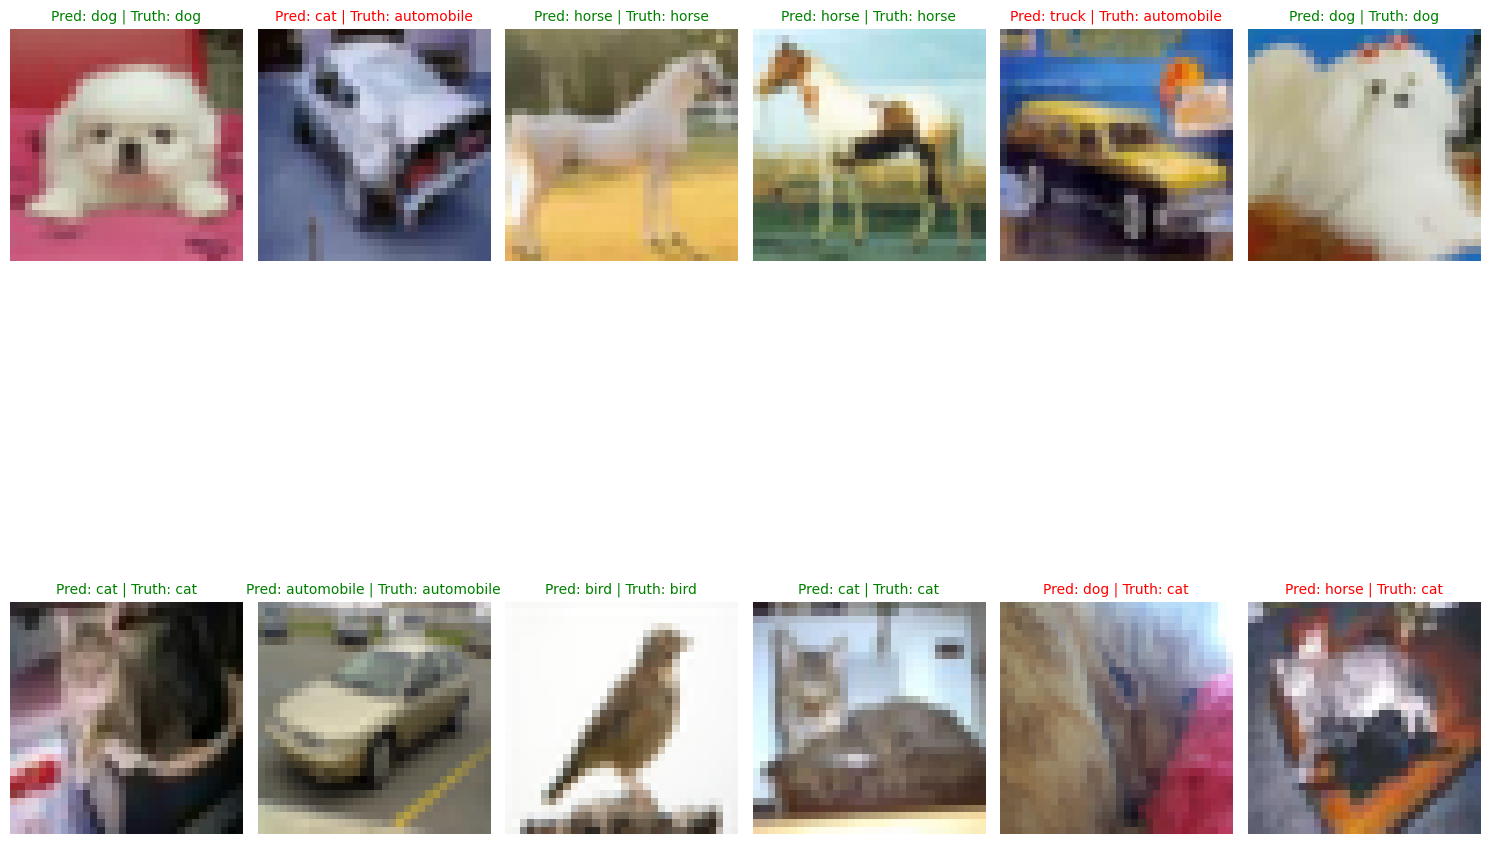

In [35]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset_norm), k=12):
    test_samples.append(sample)
    test_labels.append(label)
pred_probs = make_predictions(model=trained_model, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

# Plot predictions
plt.figure(figsize=(15, 15))
nrows = 2
ncols = 6
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    sample = (sample * STD[:, None, None] + MEAN[:, None, None]).clamp(0, 1)
    plt.imshow(sample.permute(1, 2, 0))

    # FInd the prediction (in text form, e.g. "Sandal")
    pred_label = CLASSES[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = CLASSES[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
    else:
        plt.title(title_text, fontsize=10, c="r")

    plt.axis(False)
plt.tight_layout()
plt.show()

Confusion Matrix

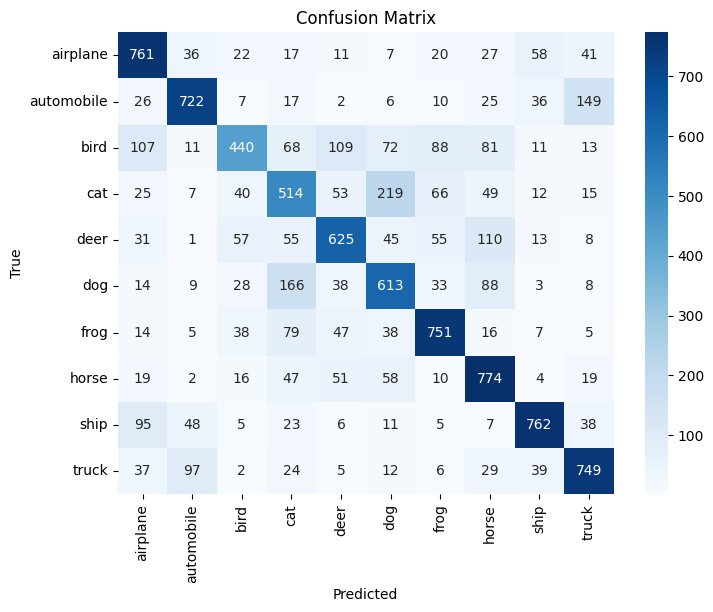

In [14]:
# Set the model
trained_model = CIFAR10VisionTransformer(img_size=32, patch_size=4, in_channels=3, num_classes=len(CLASSES), embed_dim=VIT_BEST_PARAMS['embed_dim'], depth=VIT_BEST_PARAMS['depth'], num_heads=8, mlp_dim=VIT_BEST_PARAMS['mlp_dim'], dropout=0.1).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/ViT_norm.pth"))

test_loader = DataLoader(test_dataset_norm, batch_size=TEST_BATCH_SIZE, shuffle=False)

confusion_matrix_plot(trained_model, test_loader, CLASSES, DEVICE)

### With Data Augmentation

#### Training

Training phase using the best parameters found for ViT

In [36]:
if TRAIN:
    train_loader = DataLoader(train_dataset_aug, batch_size=VIT_BEST_PARAMS['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset_aug, batch_size=TEST_BATCH_SIZE, shuffle=False)

    model = CIFAR10VisionTransformer(img_size=32, patch_size=4, in_channels=3, num_classes=len(CLASSES), embed_dim=VIT_BEST_PARAMS['embed_dim'], depth=VIT_BEST_PARAMS['depth'], num_heads=8, mlp_dim=VIT_BEST_PARAMS['mlp_dim'], dropout=0.1).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    train_loss_norm, train_acc_norm, val_loss_norm, val_acc_norm = train(model, optimizer, criterion, train_loader, val_loader, DEVICE, epochs=EPOCHS)

    torch.save(model.state_dict(), f"weights/ViT_aug.pth")
    np.savez('results/ViT_aug.npz', train_loss=train_loss_norm, train_acc=train_acc_norm, val_loss=val_loss_norm, val_acc=val_acc_norm)

#### Testing

In [37]:
# Set the model
trained_model = CIFAR10VisionTransformer(img_size=32, patch_size=4, in_channels=3, num_classes=len(CLASSES), embed_dim=VIT_BEST_PARAMS['embed_dim'], depth=VIT_BEST_PARAMS['depth'], num_heads=8, mlp_dim=VIT_BEST_PARAMS['mlp_dim'], dropout=0.1).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/ViT_aug.pth"))

# Set loss
loss_fn = nn.CrossEntropyLoss()

test_loader = DataLoader(test_dataset_aug, batch_size=TEST_BATCH_SIZE, shuffle=False)

test_time_start_on_gpu = timer()
test(model=trained_model,
    dataloader=test_loader,
    criterion=loss_fn,
    device=DEVICE)
test_time_end_on_gpu = timer()
print_execution_time(start=test_time_start_on_gpu, end=test_time_end_on_gpu, device=DEVICE)

Test loss: 0.712 | Test acc: 75.09%


Execution time on cuda : 5.254 seconds


Prediction visualization

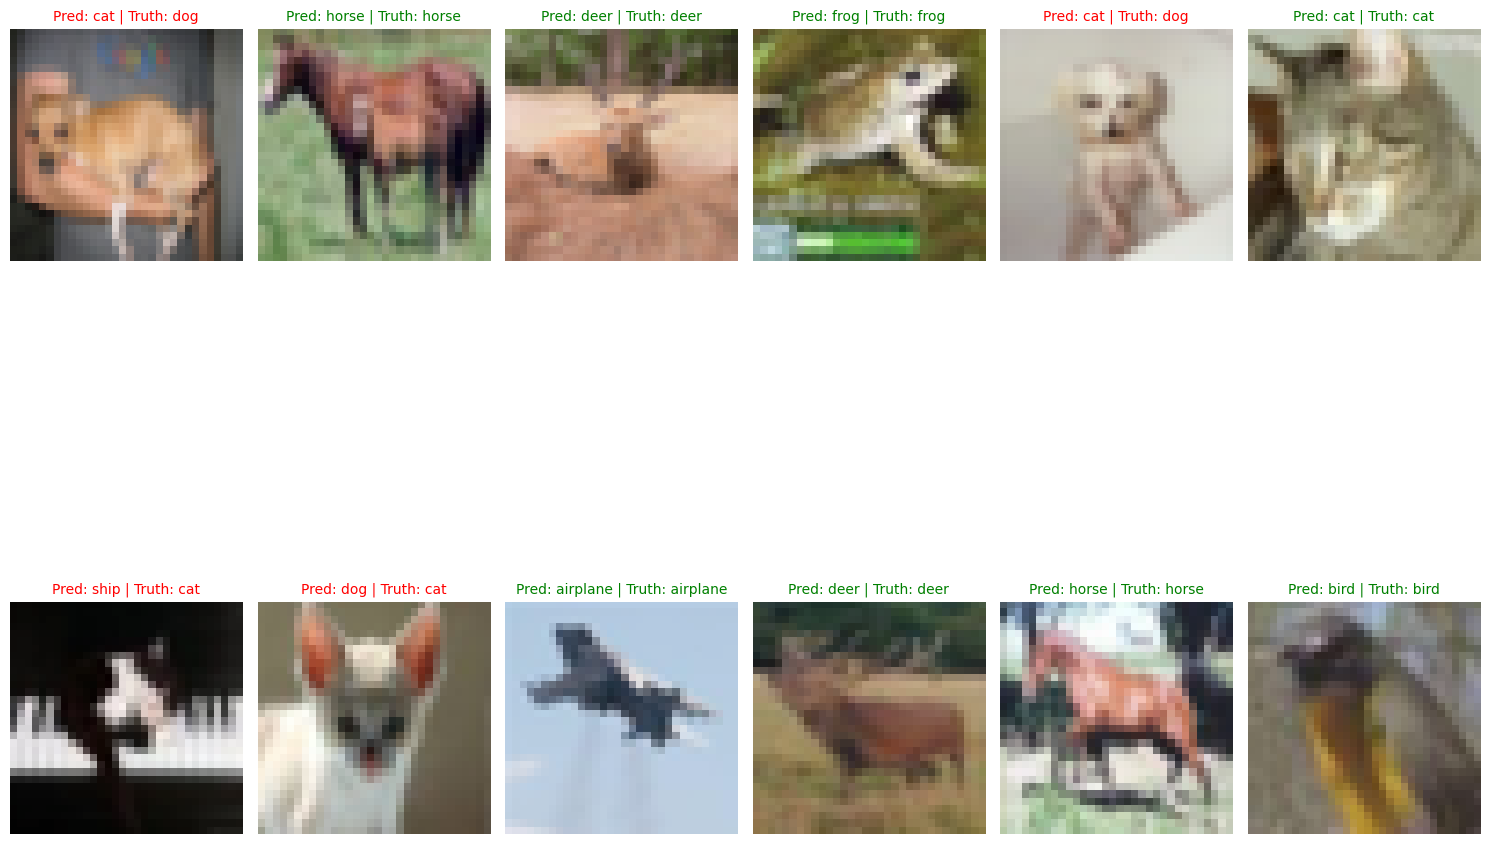

In [38]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset_norm), k=12):
    test_samples.append(sample)
    test_labels.append(label)
pred_probs = make_predictions(model=trained_model, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

# Plot predictions
plt.figure(figsize=(15, 15))
nrows = 2
ncols = 6
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    sample = (sample * STD[:, None, None] + MEAN[:, None, None]).clamp(0, 1)
    plt.imshow(sample.permute(1, 2, 0))

    # FInd the prediction (in text form, e.g. "Sandal")
    pred_label = CLASSES[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = CLASSES[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
    else:
        plt.title(title_text, fontsize=10, c="r")

    plt.axis(False)
plt.tight_layout()
plt.show()

Confusion Matrix

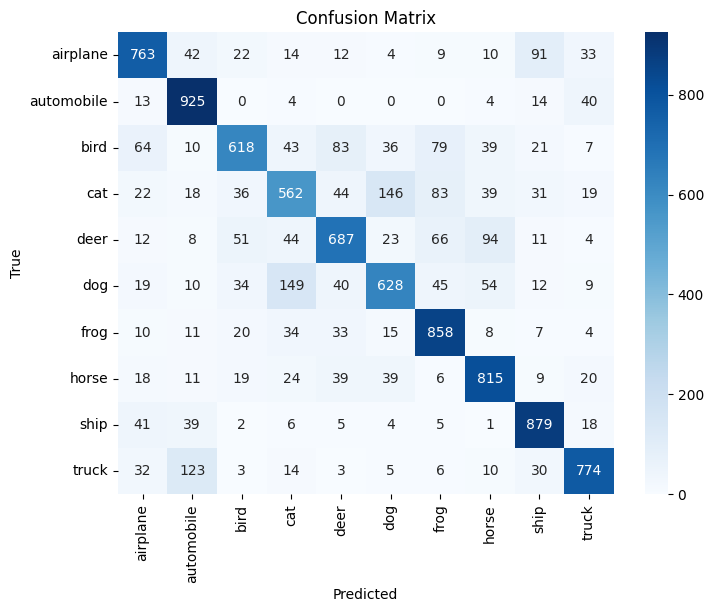

In [15]:
# Set the model
trained_model = CIFAR10VisionTransformer(img_size=32, patch_size=4, in_channels=3, num_classes=len(CLASSES), embed_dim=VIT_BEST_PARAMS['embed_dim'], depth=VIT_BEST_PARAMS['depth'], num_heads=8, mlp_dim=VIT_BEST_PARAMS['mlp_dim'], dropout=0.1).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/ViT_aug.pth"))

test_loader = DataLoader(test_dataset_norm, batch_size=TEST_BATCH_SIZE, shuffle=False)

confusion_matrix_plot(trained_model, test_loader, CLASSES, DEVICE)

### Comparison
Plot of the results obained during the training with normalization and data augmentation

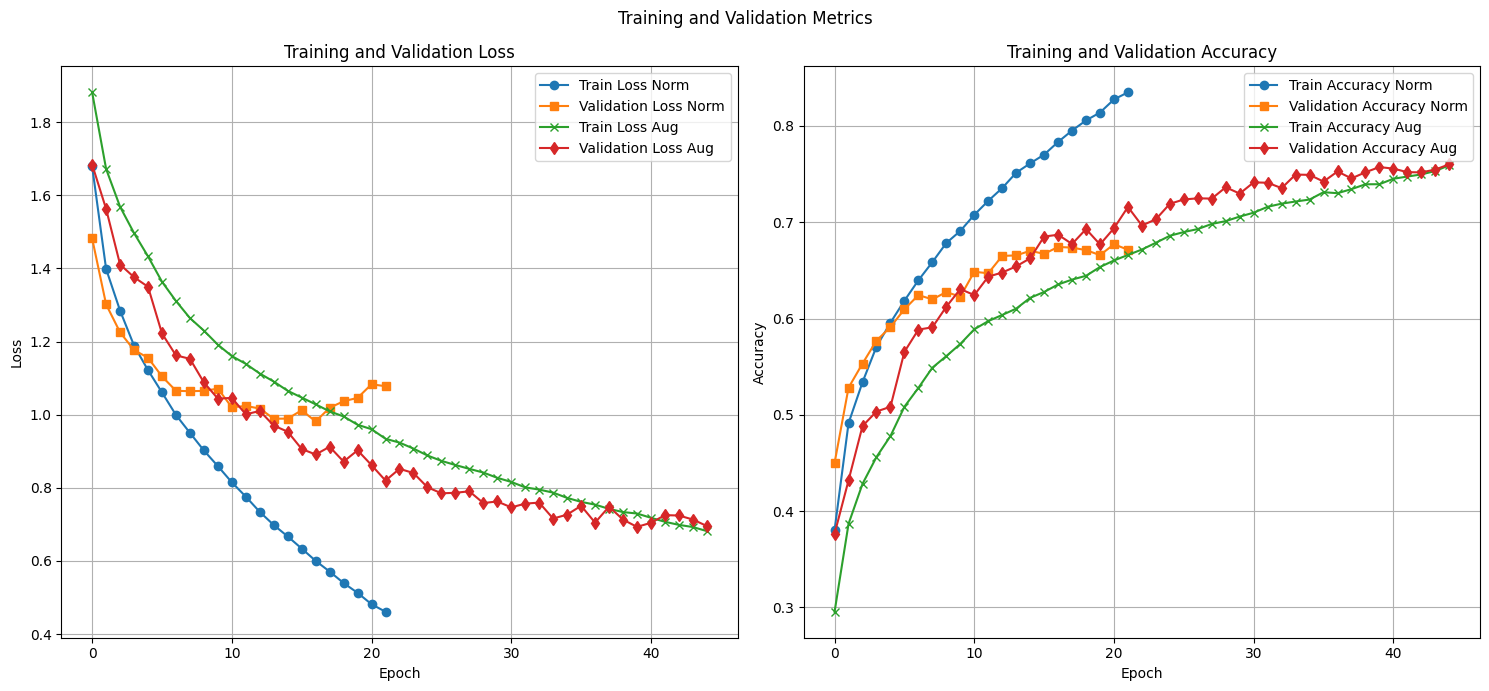

In [39]:
plot_results('results/ViT_norm.npz', 'results/ViT_aug.npz')

## MLP Mixer

### Normalized

#### Training

Training phase with selection of best parameters for the MLP-Mixer model

In [40]:
if TRAIN:
    # Hyperparameter grid
    param_grid = {
        'embed_dim': [64, 128],
        'depth': [4, 6, 8],
        'token_intermediate_dim': [64, 128],
        'channel_intermediate_dim': [64, 128],
        'batch_size': [32, 64, 128]
    }
    param_combinations = list(itertools.product(*param_grid.values()))

    # Results
    results = {}

    # Split the train dataset into training and validation sets
    test_abs = int(len(train_dataset_norm) * 0.8)
    train_subset, val_subset = random_split(
        train_dataset_norm, [test_abs, len(train_dataset_norm) - test_abs]
    )

    best_acc = None

    # Tuning loop
    for embed_dim, depth, token_intermediate_dim, channel_intermediate_dim, batch_size in param_combinations:
        print(f"Tuning: embed_dim={embed_dim}, depth={depth}, token_intermediate_dim={token_intermediate_dim}, channel_intermediate_dim={channel_intermediate_dim}, batch_size={batch_size}")

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=TEST_BATCH_SIZE, shuffle=False)

        model = CIFAR10MLPMixer(in_channels=3, 
                                embed_dim=embed_dim, 
                                num_classes=len(CLASSES), 
                                patch_size=4, 
                                img_size=32, 
                                depth=depth, 
                                token_intermediate_dim=token_intermediate_dim, 
                                channel_intermediate_dim=channel_intermediate_dim, 
                                dropout=0.1).to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

        train_loss, train_acc, val_loss, val_acc = train(model, optimizer, criterion, train_loader, val_loader, DEVICE, epochs=EPOCHS)
        
        if best_acc is None or max(val_acc) > best_acc:
            best_acc = max(val_acc)

        results[(embed_dim, depth, token_intermediate_dim, channel_intermediate_dim, batch_size)] = max(val_acc)
        print(f"Max Accuracy: {max(val_acc)*100:.2f}%\n")

    best_params = max(results, key=results.get)
    print("==============================")
    print(f"Best config: embed_dim={best_params[0]}, depth={best_params[1]}, token_intermediate_dim={best_params[2]}, channel_intermediate_dim={best_params[3]}, batch_size={best_params[4]}")
    print(f"Accuracy: {results[best_params]*100:.2f}%")
    print("==============================")

Training phase using the best parameters found for MLP-Mixer

In [41]:
if TRAIN:
    # Split the train dataset into training and validation sets
    test_abs = int(len(train_dataset_norm) * 0.8)
    train_subset, val_subset = random_split(
        train_dataset_norm, [test_abs, len(train_dataset_norm) - test_abs]
    )

    train_loader = DataLoader(train_subset, batch_size=MLP_MIXER_BEST_PARAMS['batch_size'], shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=TEST_BATCH_SIZE, shuffle=False)

    model = CIFAR10MLPMixer(in_channels=3, 
                            embed_dim=MLP_MIXER_BEST_PARAMS['embed_dim'], 
                            num_classes=len(CLASSES), 
                            patch_size=4, 
                            img_size=32, 
                            depth=MLP_MIXER_BEST_PARAMS['depth'], 
                            token_intermediate_dim=MLP_MIXER_BEST_PARAMS['token_intermediate_dim'], 
                            channel_intermediate_dim=MLP_MIXER_BEST_PARAMS['channel_intermediate_dim'], 
                            dropout=0.1).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    train_loss_norm, train_acc_norm, val_loss_norm, val_acc_norm = train(model, optimizer, criterion, train_loader, val_loader, DEVICE, epochs=EPOCHS)

    torch.save(model.state_dict(), f"weights/MLP_norm.pth")
    np.savez('results/MLP_norm.npz', train_loss=train_loss_norm, train_acc=train_acc_norm, val_loss=val_loss_norm, val_acc=val_acc_norm)

#### Testing

In [42]:
# Set the model
trained_model = CIFAR10MLPMixer(in_channels=3, 
                                embed_dim=MLP_MIXER_BEST_PARAMS['embed_dim'], 
                                num_classes=len(CLASSES), 
                                patch_size=4, 
                                img_size=32, 
                                depth=MLP_MIXER_BEST_PARAMS['depth'], 
                                token_intermediate_dim=MLP_MIXER_BEST_PARAMS['token_intermediate_dim'], 
                                channel_intermediate_dim=MLP_MIXER_BEST_PARAMS['channel_intermediate_dim'], 
                                dropout=0.1).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/MLP_norm.pth"))

# Set loss
loss_fn = nn.CrossEntropyLoss()

test_loader = DataLoader(test_dataset_norm, batch_size=TEST_BATCH_SIZE, shuffle=False)

test_time_start_on_gpu = timer()
test(model=trained_model,
    dataloader=test_loader,
    criterion=loss_fn,
    device=DEVICE)
test_time_end_on_gpu = timer()
print_execution_time(start=test_time_start_on_gpu, end=test_time_end_on_gpu, device=DEVICE)

Test loss: 0.884 | Test acc: 71.73%


Execution time on cuda : 3.646 seconds


Prediction visualization

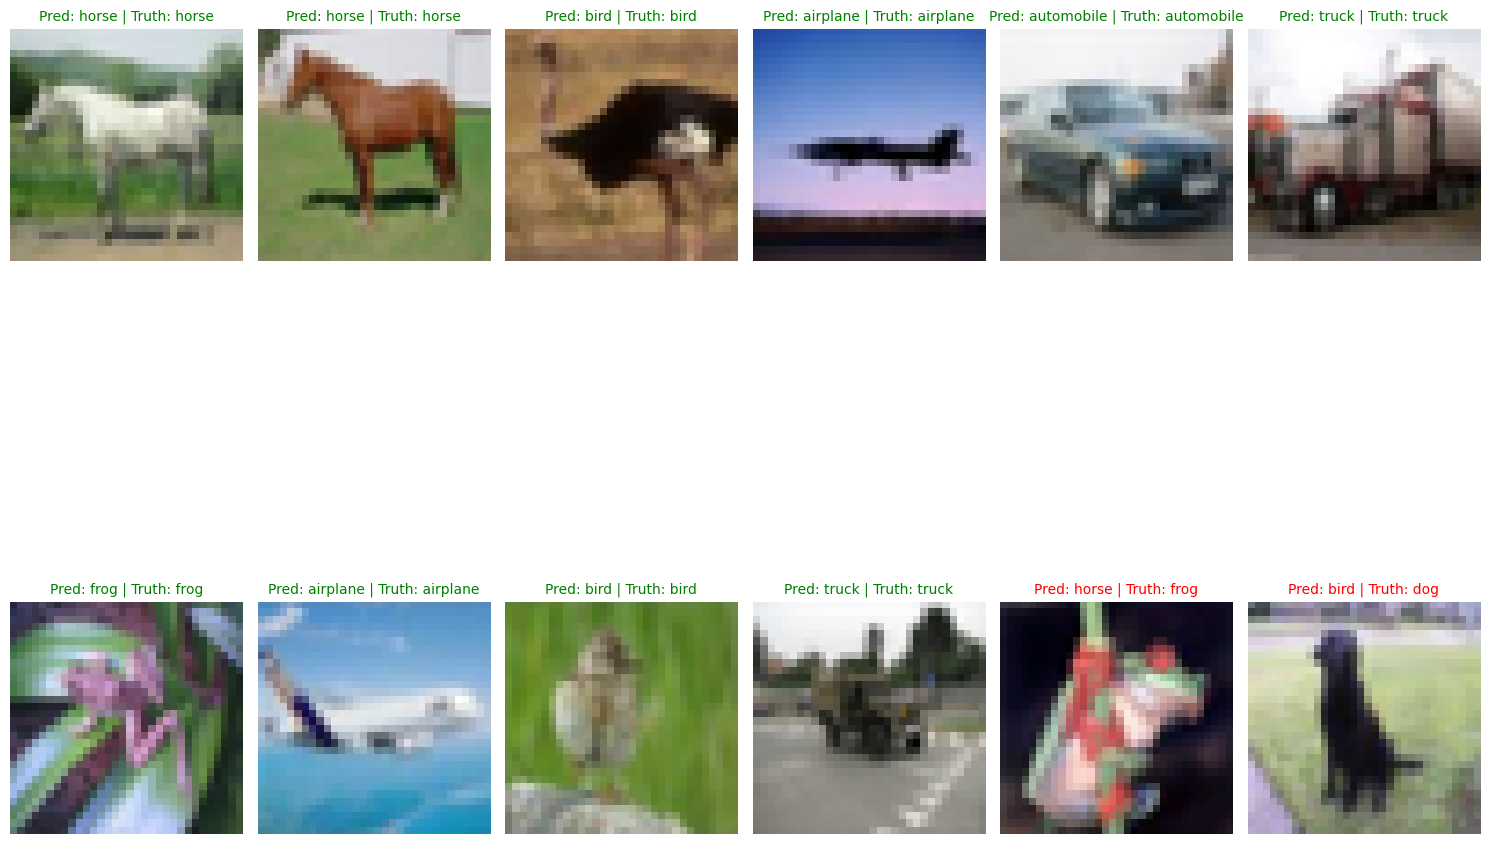

In [43]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset_norm), k=12):
    test_samples.append(sample)
    test_labels.append(label)
pred_probs = make_predictions(model=trained_model, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

# Plot predictions
plt.figure(figsize=(15, 15))
nrows = 2
ncols = 6
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    sample = (sample * STD[:, None, None] + MEAN[:, None, None]).clamp(0, 1)
    plt.imshow(sample.permute(1, 2, 0))

    # FInd the prediction (in text form, e.g. "Sandal")
    pred_label = CLASSES[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = CLASSES[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
    else:
        plt.title(title_text, fontsize=10, c="r")

    plt.axis(False)
plt.tight_layout()
plt.show()

Confusion Matrix

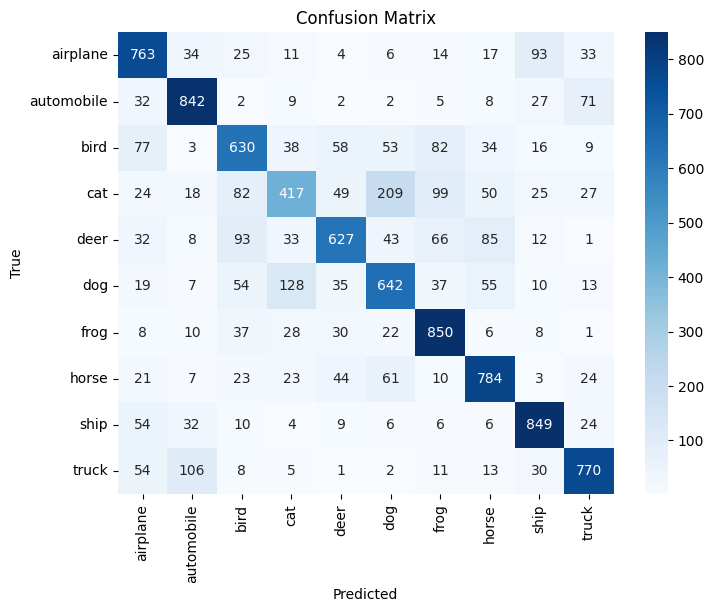

In [16]:
# Set the model
trained_model = CIFAR10MLPMixer(in_channels=3, 
                                embed_dim=MLP_MIXER_BEST_PARAMS['embed_dim'], 
                                num_classes=len(CLASSES), 
                                patch_size=4, 
                                img_size=32, 
                                depth=MLP_MIXER_BEST_PARAMS['depth'], 
                                token_intermediate_dim=MLP_MIXER_BEST_PARAMS['token_intermediate_dim'], 
                                channel_intermediate_dim=MLP_MIXER_BEST_PARAMS['channel_intermediate_dim'], 
                                dropout=0.1).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/MLP_norm.pth"))

test_loader = DataLoader(test_dataset_norm, batch_size=TEST_BATCH_SIZE, shuffle=False)

confusion_matrix_plot(trained_model, test_loader, CLASSES, DEVICE)

### With Data Augmentation

#### Training

Training phase using the best parameters found for MLP-Mixer

In [44]:
if TRAIN:
    train_loader = DataLoader(train_dataset_aug, batch_size=MLP_MIXER_BEST_PARAMS['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset_aug, batch_size=TEST_BATCH_SIZE, shuffle=False)

    model = CIFAR10MLPMixer(in_channels=3, 
                            embed_dim=MLP_MIXER_BEST_PARAMS['embed_dim'], 
                            num_classes=len(CLASSES), 
                            patch_size=4, 
                            img_size=32, 
                            depth=MLP_MIXER_BEST_PARAMS['depth'], 
                            token_intermediate_dim=MLP_MIXER_BEST_PARAMS['token_intermediate_dim'], 
                            channel_intermediate_dim=MLP_MIXER_BEST_PARAMS['channel_intermediate_dim'], 
                            dropout=0.1).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    train_loss_norm, train_acc_norm, val_loss_norm, val_acc_norm = train(model, optimizer, criterion, train_loader, val_loader, DEVICE, epochs=EPOCHS)

    torch.save(model.state_dict(), f"weights/MLP_aug.pth")
    np.savez('results/MLP_aug.npz', train_loss=train_loss_norm, train_acc=train_acc_norm, val_loss=val_loss_norm, val_acc=val_acc_norm)

#### Testing

In [45]:
# Set the model
trained_model = CIFAR10MLPMixer(in_channels=3, 
                                embed_dim=MLP_MIXER_BEST_PARAMS['embed_dim'], 
                                num_classes=len(CLASSES), 
                                patch_size=4, 
                                img_size=32, 
                                depth=MLP_MIXER_BEST_PARAMS['depth'], 
                                token_intermediate_dim=MLP_MIXER_BEST_PARAMS['token_intermediate_dim'], 
                                channel_intermediate_dim=MLP_MIXER_BEST_PARAMS['channel_intermediate_dim'], 
                                dropout=0.1).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/MLP_aug.pth"))

# Set loss
loss_fn = nn.CrossEntropyLoss()

test_loader = DataLoader(test_dataset_aug, batch_size=TEST_BATCH_SIZE, shuffle=False)

test_time_start_on_gpu = timer()
test(model=trained_model,
    dataloader=test_loader,
    criterion=loss_fn,
    device=DEVICE)
test_time_end_on_gpu = timer()
print_execution_time(start=test_time_start_on_gpu, end=test_time_end_on_gpu, device=DEVICE)

Test loss: 0.782 | Test acc: 72.81%


Execution time on cuda : 3.673 seconds


Prediction visualization

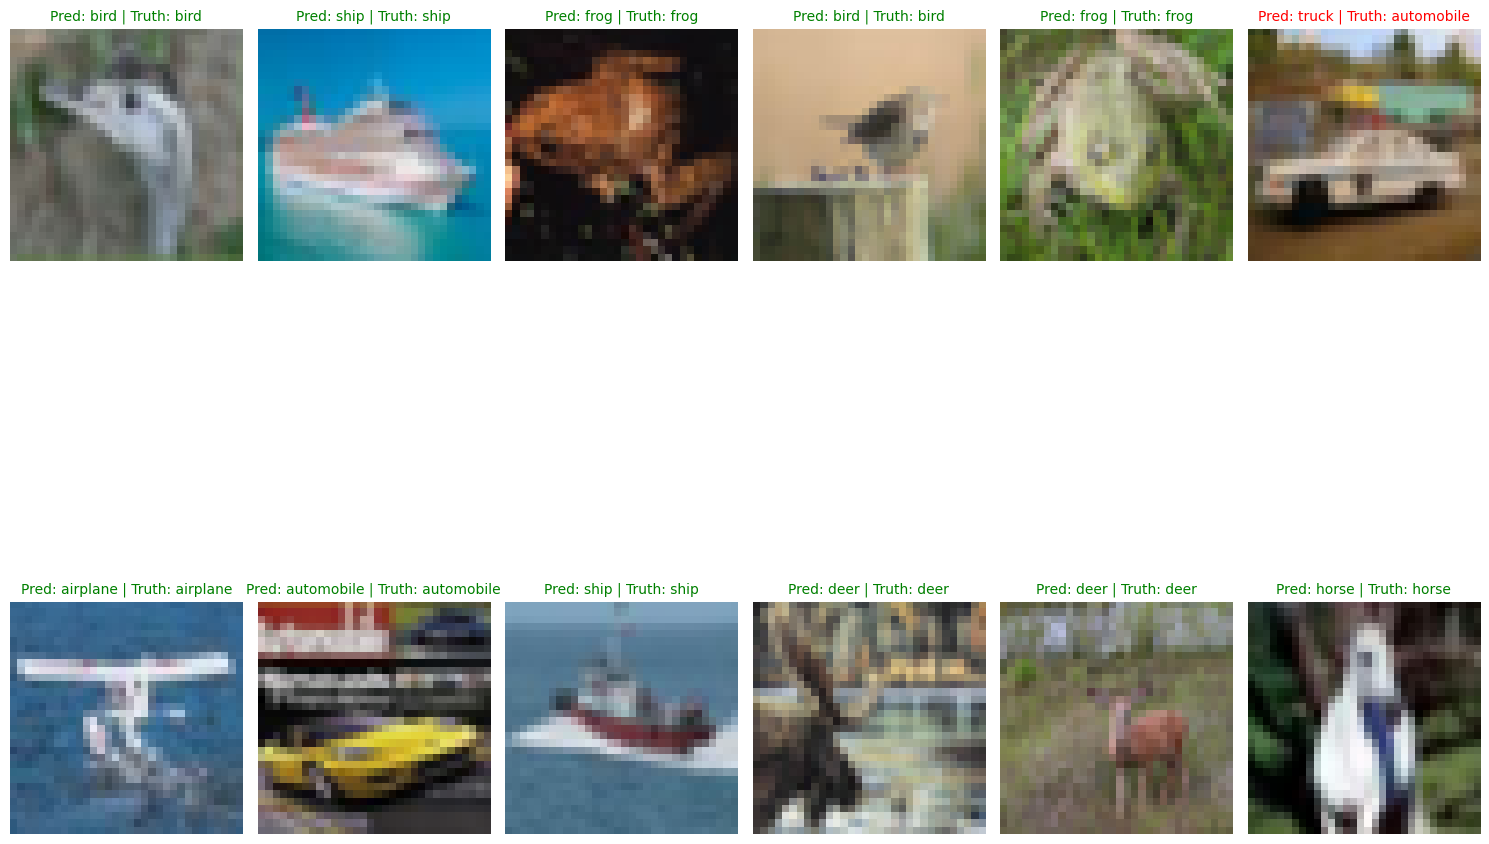

In [46]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset_norm), k=12):
    test_samples.append(sample)
    test_labels.append(label)
pred_probs = make_predictions(model=trained_model, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

# Plot predictions
plt.figure(figsize=(15, 15))
nrows = 2
ncols = 6
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    sample = (sample * STD[:, None, None] + MEAN[:, None, None]).clamp(0, 1)
    plt.imshow(sample.permute(1, 2, 0))

    # FInd the prediction (in text form, e.g. "Sandal")
    pred_label = CLASSES[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = CLASSES[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
    else:
        plt.title(title_text, fontsize=10, c="r")

    plt.axis(False)
plt.tight_layout()
plt.show()

Confusion Matrix

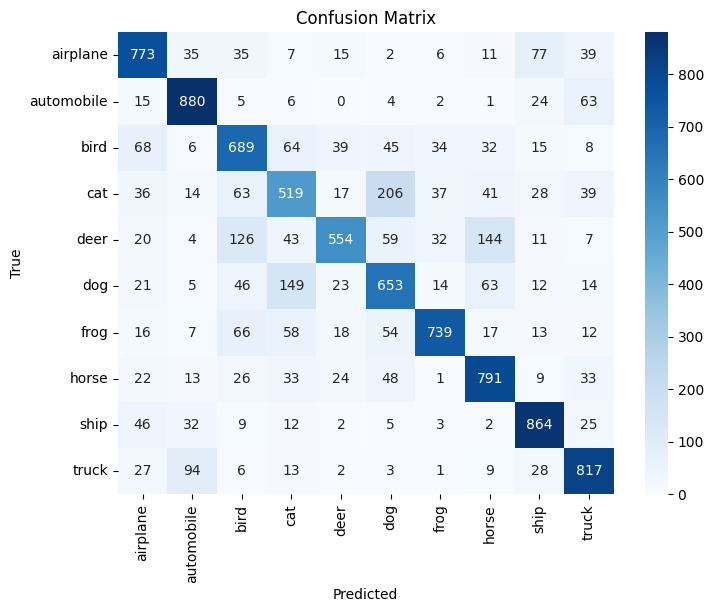

In [17]:
# Set the model
trained_model = CIFAR10MLPMixer(in_channels=3, 
                                embed_dim=MLP_MIXER_BEST_PARAMS['embed_dim'], 
                                num_classes=len(CLASSES), 
                                patch_size=4, 
                                img_size=32, 
                                depth=MLP_MIXER_BEST_PARAMS['depth'], 
                                token_intermediate_dim=MLP_MIXER_BEST_PARAMS['token_intermediate_dim'], 
                                channel_intermediate_dim=MLP_MIXER_BEST_PARAMS['channel_intermediate_dim'], 
                                dropout=0.1).to(DEVICE)
# Load the best model state
trained_model.load_state_dict(torch.load("weights/MLP_aug.pth"))

test_loader = DataLoader(test_dataset_norm, batch_size=TEST_BATCH_SIZE, shuffle=False)

confusion_matrix_plot(trained_model, test_loader, CLASSES, DEVICE)

### Comparison
Plot of the results obained during the training with normalization and data augmentation

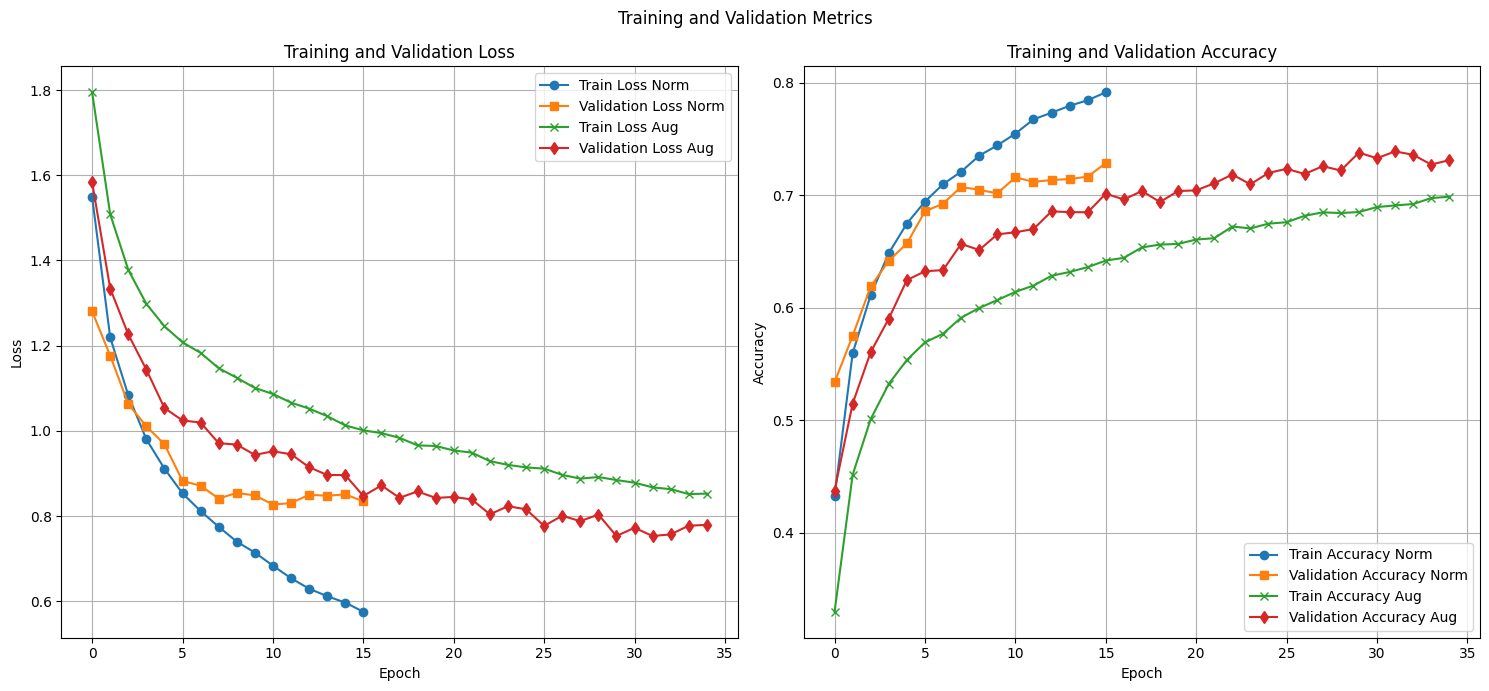

In [47]:
plot_results('results/MLP_norm.npz', 'results/MLP_aug.npz')